In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import collections
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import pymc3 as pm
from pymc3 import  *

In [ ]:
!pip install arviz

     |████████████████████████████████| 1.5MB 5.8MB/s 
     |████████████████████████████████| 4.3MB 17.2MB/s 
     |████████████████████████████████| 727kB 34.2MB/s 
     |████████████████████████████████| 296kB 44.2MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


In [4]:
df_vg = pd.read_csv("/content/Video_Games_Sales_as_at_22_Dec_2016.csv")

df_vg

Name Platform  ...  Developer Rating
0                         Wii Sports      Wii  ...   Nintendo      E
1                  Super Mario Bros.      NES  ...        NaN    NaN
2                     Mario Kart Wii      Wii  ...   Nintendo      E
3                  Wii Sports Resort      Wii  ...   Nintendo      E
4           Pokemon Red/Pokemon Blue       GB  ...        NaN    NaN
...                              ...      ...  ...        ...    ...
16714  Samurai Warriors: Sanada Maru      PS3  ...        NaN    NaN
16715               LMA Manager 2007     X360  ...        NaN    NaN
16716        Haitaka no Psychedelica      PSV  ...        NaN    NaN
16717               Spirits & Spells      GBA  ...        NaN    NaN
16718            Winning Post 8 2016      PSV  ...        NaN    NaN

[16719 rows x 16 columns]

In [ ]:
early = ["2600"]
eightbit = ["NES", "GB", "GG", "WS"]
sixteenbit = ["SNES", "GBA", "GEN", "NG", "TG16", "SCD"]
early3d = ["PS", "N64", "SAT"]
cdrom = ["3DO", "PCFX"]
sixththgen = ["PS2", "DC", "XB", "GC"]
lastgen = ["X360", "PS3", "Wii"]
aughts_hh = ["DS", "PSP"]
tens_handheld = ["3DS", "PSV"]
pc = ["PC"]
current_gen = ["PS4", "WiiU", "XOne"]

In [ ]:
ls_platgen = []

for plat in df_vg["Platform"].unique():
  sub_genre = df_vg[df_vg["Platform"] == plat]["Genre"]
  count = sub_genre.value_counts()  

  if plat in early:
    gen = "Early"
  elif plat in eightbit:
    gen = "8Bit"
  elif plat in sixteenbit:
    gen = '16Bit'
  elif plat in early3d:
    gen = "Early3D"
  elif plat in cdrom:
    continue
    gen = "CD-ROM Console"
  elif plat in sixththgen:
    gen = "6thGen"
  elif plat in lastgen:
    gen = "LastGen"
  elif plat in aughts_hh:
    gen = "Aughts Handheld"
  elif plat in tens_handheld:
    gen = "New Tens Handheld"
  elif plat in pc:
    gen = "PC"
  else:
    gen = "CurrentGen"

  for index, row in count.iteritems():    
    ls_platgen.append((plat, index, np.log10(row), gen))

df_platgen = pd.DataFrame.from_records(ls_platgen, columns=["Platform", "Genre", "Count", "Generation"])

df_platgen

Platform       Genre     Count Generation
0        Wii        Misc  2.447158    LastGen
1        Wii      Sports  2.414973    LastGen
2        Wii      Action  2.374748    LastGen
3        Wii      Racing  1.968483    LastGen
4        Wii  Simulation  1.939519    LastGen
..       ...         ...       ...        ...
284       NG    Fighting  1.041393      16Bit
285       NG      Sports  0.000000      16Bit
286     TG16     Shooter  0.000000      16Bit
287     TG16   Adventure  0.000000      16Bit
288       GG    Platform  0.000000       8Bit

[289 rows x 4 columns]

<Figure size 4464x2304 with 0 Axes>

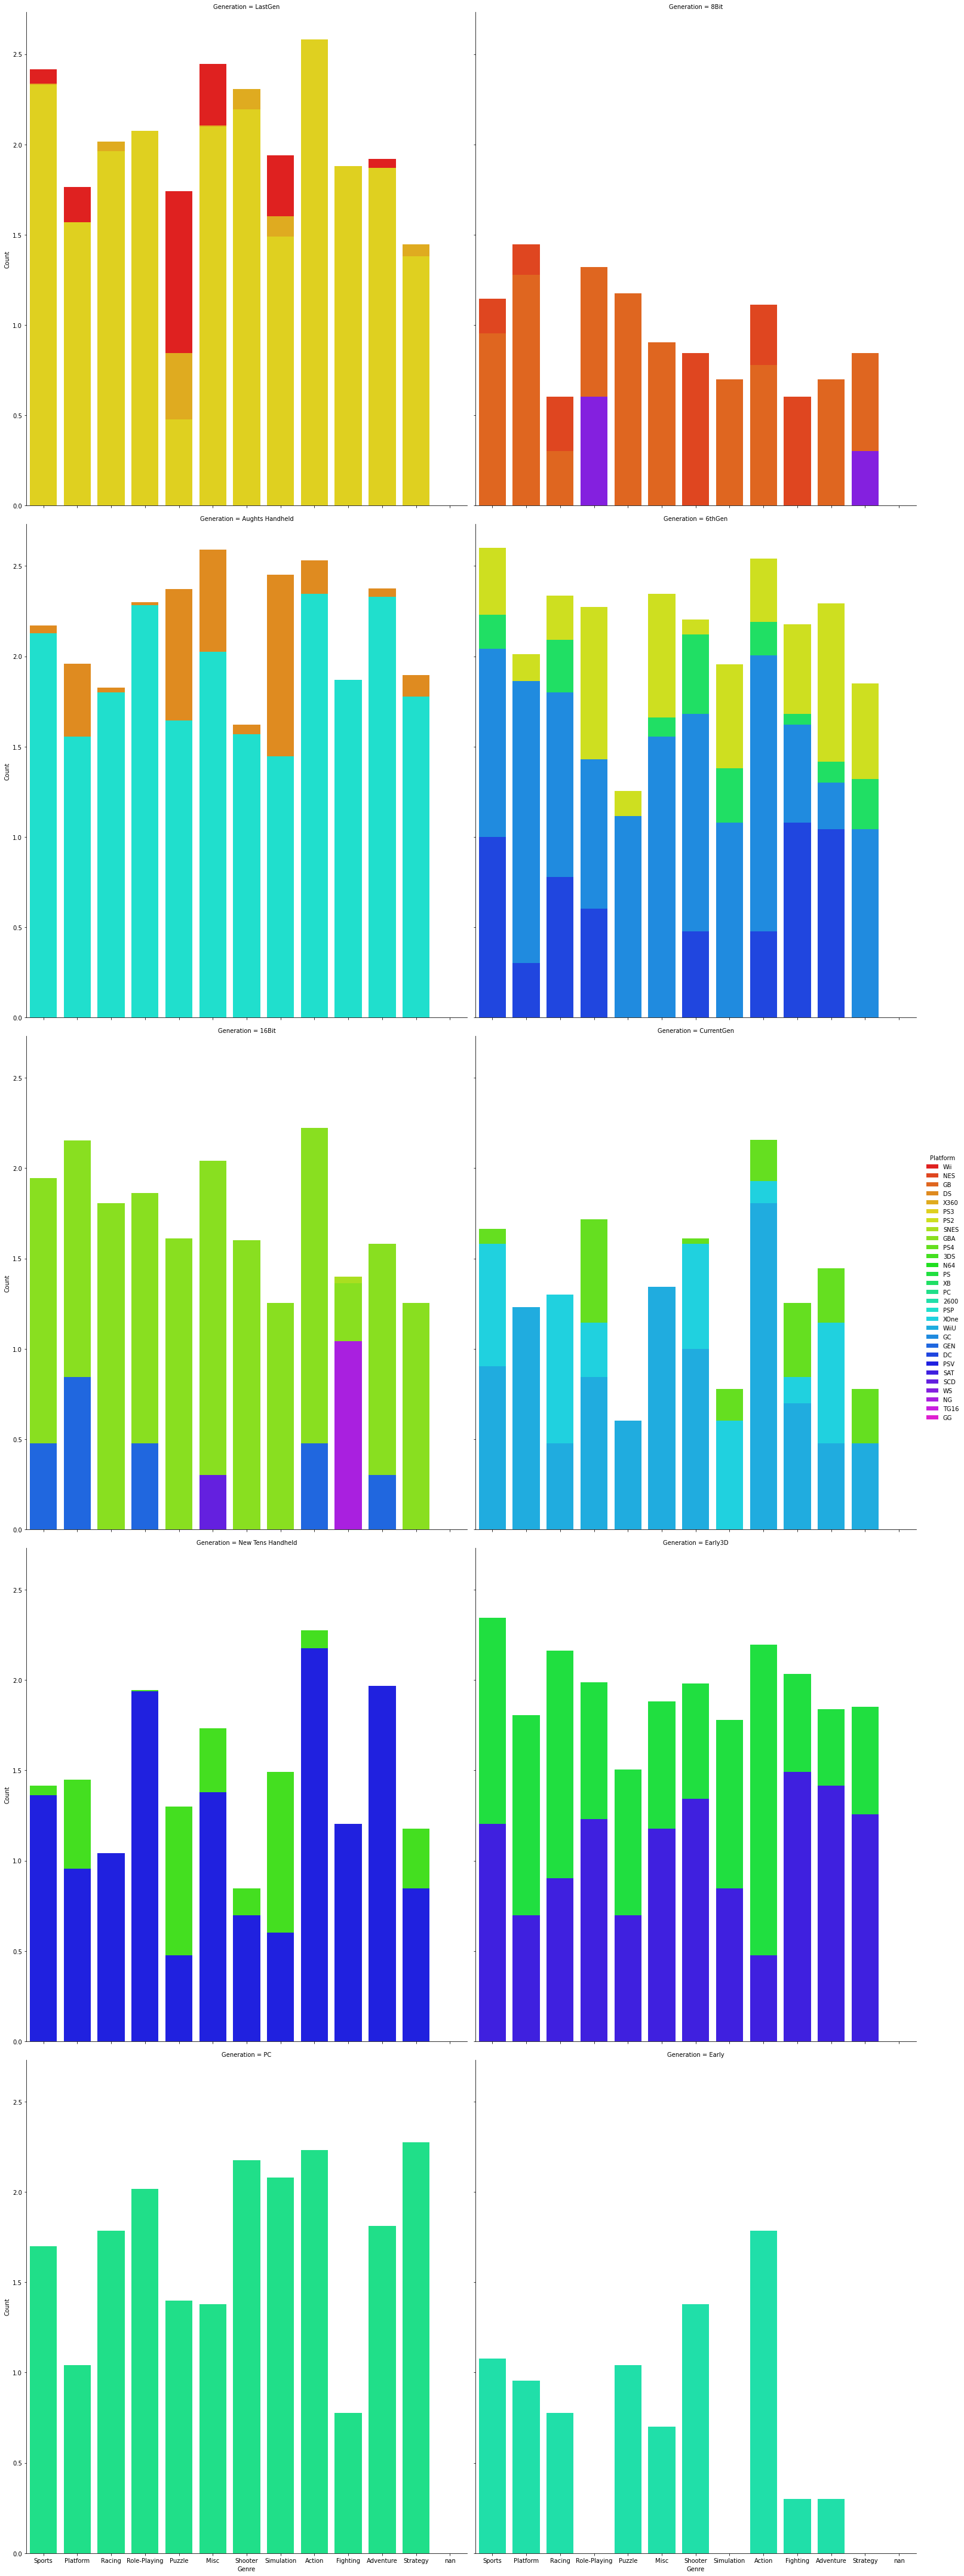

In [ ]:
fig = plt.gcf()

fig.set_size_inches(62, 32)
g = sns.FacetGrid(df_platgen, col="Generation", hue="Platform", palette="gist_rainbow", col_wrap=2, height=12, aspect=0.9)
g.map(sns.barplot, "Genre", "Count", order=df_vg["Genre"].unique())
g.add_legend()
plt.show()

In [ ]:
df_sales = df_vg.loc[:, ["Publisher", "NA_Sales", "EU_Sales", "JP_Sales"]].groupby("Publisher", as_index=False).sum()

top_sales = df_sales.sort_values(by=["NA_Sales"], ascending=False)[:10]

top_sales

Publisher  NA_Sales  EU_Sales  JP_Sales
361                     Nintendo    816.97    419.01    458.15
139              Electronic Arts    599.50    373.91     14.35
21                    Activision    432.59    215.90      6.71
458  Sony Computer Entertainment    266.17    186.56     74.15
529                      Ubisoft    252.74    161.99      7.52
498         Take-Two Interactive    222.94    119.25      5.93
492                          THQ    207.72     93.78      5.01
325       Microsoft Game Studios    157.43     68.64      3.30
53                         Atari    109.84     27.00     10.71
448                         Sega    108.61     80.66     57.06

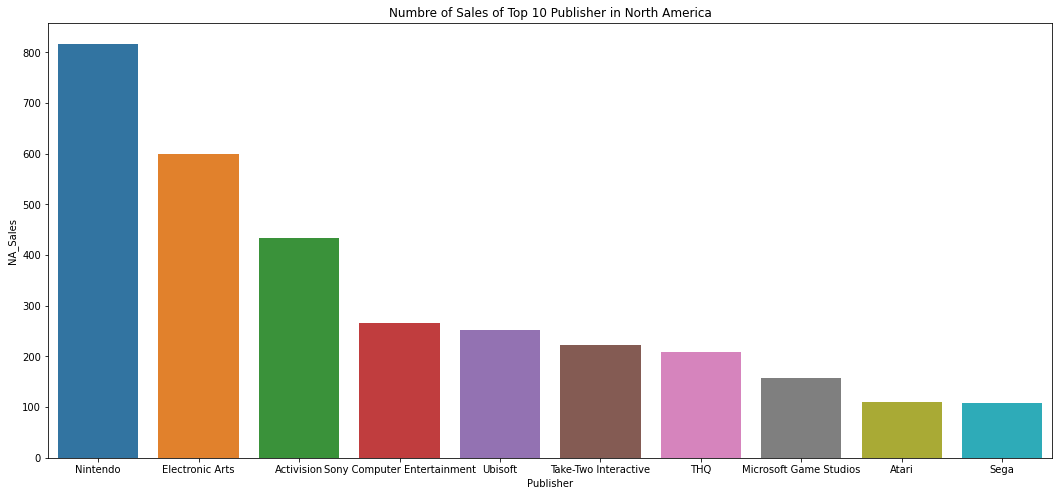

In [ ]:
fig = plt.gcf()

fig.set_size_inches(18, 8)
ax = sns.barplot(data=top_sales, x="Publisher", y="NA_Sales")
plt.title("Numbre of Sales of Top 10 Publisher in North America")
plt.show()

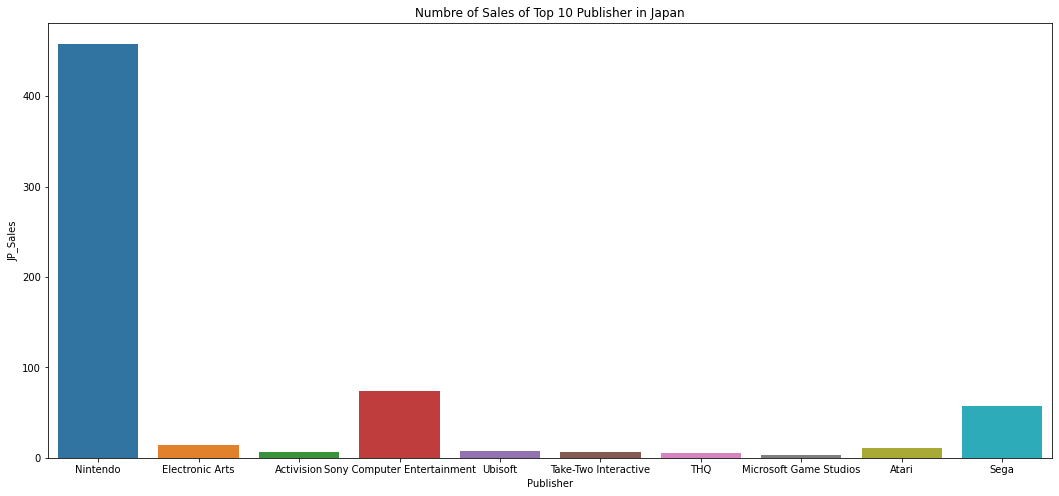

In [ ]:
fig = plt.gcf()

fig.set_size_inches(18, 8)
ax = sns.barplot(data=top_sales, x="Publisher", y="JP_Sales")
plt.title("Numbre of Sales of Top 10 Publisher in Japan")
plt.show()

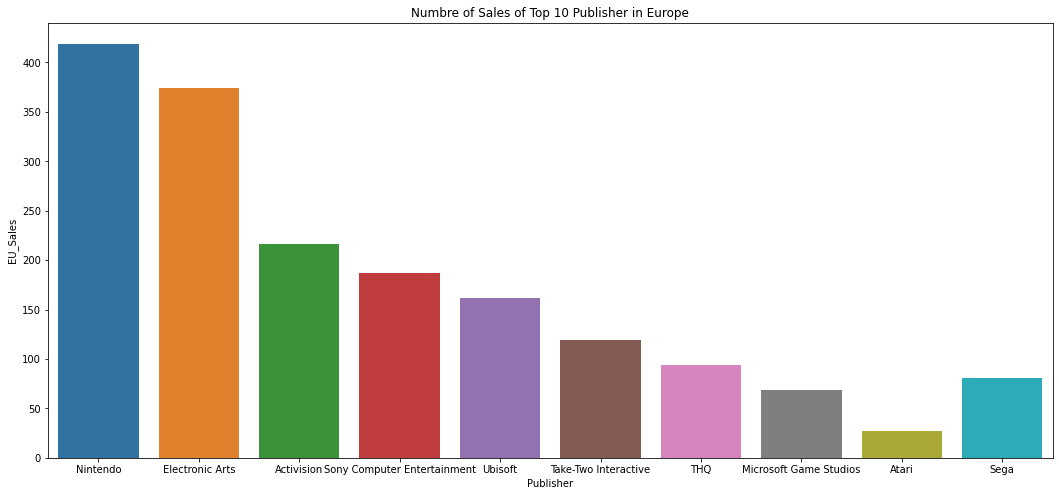

In [ ]:
fig = plt.gcf()

fig.set_size_inches(18, 8)
ax = sns.barplot(data=top_sales, x="Publisher", y="EU_Sales")
plt.title("Numbre of Sales of Top 10 Publisher in Europe")
plt.show()

In [ ]:
ls_transpose = []

for pub in top_sales["Publisher"]:
  nas = top_sales[top_sales["Publisher"] == pub]["NA_Sales"]
  jps = top_sales[top_sales["Publisher"] == pub]["JP_Sales"]
  eus = top_sales[top_sales["Publisher"] == pub]["EU_Sales"]

  for na in nas:
    ls_transpose.append((pub, na, "North America"))
  
  for jp in jps:
    ls_transpose.append((pub, jp, "Japan"))

  for eu in eus:
    ls_transpose.append((pub, eu, "Europe"))


df_ts_t = pd.DataFrame.from_records(ls_transpose, columns=["Publisher", "Millions Sold", "Region"])

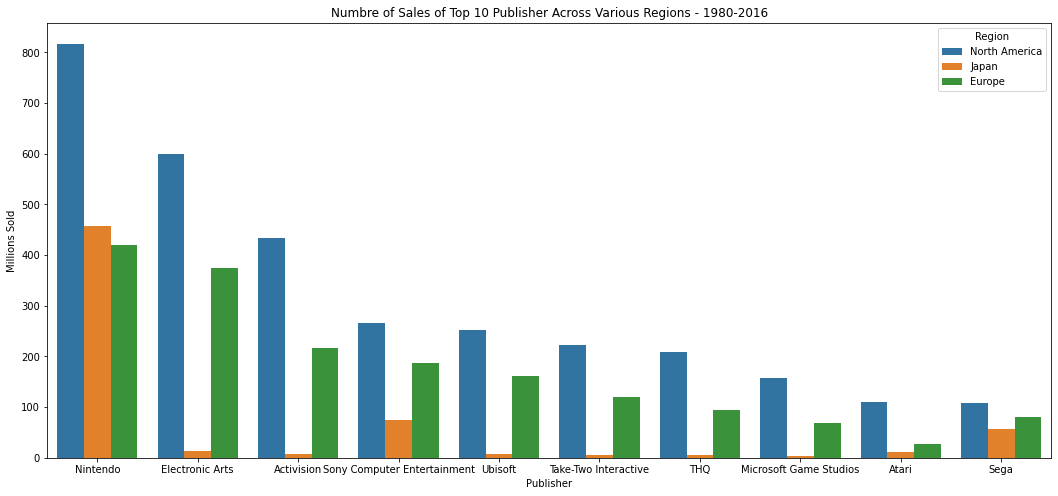

In [ ]:
fig = plt.gcf()

fig.set_size_inches(18, 8)
ax = sns.barplot(data=df_ts_t, x="Publisher", y="Millions Sold", hue="Region")
plt.title("Numbre of Sales of Top 10 Publisher Across Various Regions - 1980-2016")
plt.show()

In [ ]:
df_vg["Year_of_Release"].min()

1980.0

In [ ]:
low_sales = df_sales.sort_values(by=["NA_Sales"], ascending=True)[:10]

ls_transpose = []

for pub in low_sales["Publisher"]:
  nas = low_sales[low_sales["Publisher"] == pub]["NA_Sales"]
  jps = low_sales[low_sales["Publisher"] == pub]["JP_Sales"]
  eus = low_sales[low_sales["Publisher"] == pub]["EU_Sales"]

  for na in nas:
    ls_transpose.append((pub, na, "North America"))
  
  for jp in jps:
    ls_transpose.append((pub, jp, "Japan"))

  for eu in eus:
    ls_transpose.append((pub, eu, "Europe"))


df_ls_t = pd.DataFrame.from_records(ls_transpose, columns=["Publisher", "Millions Sold", "Region"])

df_ls_t


Publisher  Millions Sold         Region
0                 Locus           0.00  North America
1                 Locus           0.07          Japan
2                 Locus           0.00         Europe
3                   Pow           0.00  North America
4                   Pow           0.05          Japan
5                   Pow           0.00         Europe
6                   Elf           0.00  North America
7                   Elf           0.64          Japan
8                   Elf           0.00         Europe
9   Media Entertainment           0.00  North America
10  Media Entertainment           0.01          Japan
11  Media Entertainment           0.00         Europe
12        Media Factory           0.00  North America
13        Media Factory           0.29          Japan
14        Media Factory           0.00         Europe
15            mixi, Inc           0.00  North America
16            mixi, Inc           0.87          Japan
17            mixi, Inc           0.00         Europe
18          Media Works           0.00  North America
19          Media Works           0.18          Japan
20          Media Works           0.00         Europe
21               Plenty           0.00  North America
22               Plenty           0.02          Japan
23               Plenty           0.00         Europe
24                Epoch           0.00  North America
25                Epoch           0.99          Japan
26                Epoch           0.00         Europe
27      Evolution Games           0.00  North America
28      Evolution Games           0.06          Japan
29      Evolution Games           0.00         Europe

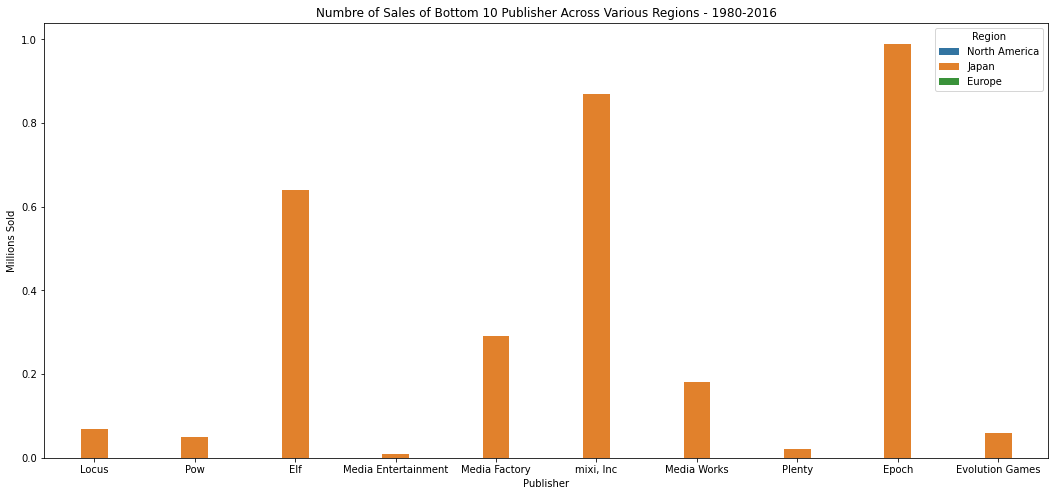

In [ ]:
fig = plt.gcf()

fig.set_size_inches(18, 8)
ax = sns.barplot(data=df_ls_t, x="Publisher", y="Millions Sold", hue="Region")
plt.title("Numbre of Sales of Bottom 10 Publisher Across Various Regions - 1980-2016")
plt.show()

In [ ]:
ls_year_genre = []

for name, group in df_vg.loc[:, ["Year_of_Release", "Genre"]].groupby("Year_of_Release"):
  count = group["Genre"].value_counts()

  if name >= 1980 and name < 1985:
    dec = "1980-85"
  elif name >= 1986 and name < 1990:
    dec = "1986-90"
  elif name >= 1990 and name < 1995:
    dec = "1990-95"
  elif name >= 1955 and name < 2000:
    dec = "1995-2000"
  elif name >= 2000 and name < 2005:
    dec = "2000-2005"
  elif name >= 2005 and name < 2010:
    dec = "2005-10"
  elif name >= 2010 and name < 2015:
    dec = "2010-2015"
  else:
    dec = "2015-?"

  for index, item in count.iteritems():
    ls_year_genre.append((name, index, np.log10(item), dec))


df_year_genre = pd.DataFrame.from_records(ls_year_genre, columns=["Release_Year", "Genre", "Count", "Decade"])

df_year_genre

Release_Year         Genre     Count   Decade
0          1980.0          Misc  0.602060  1980-85
1          1980.0       Shooter  0.301030  1980-85
2          1980.0        Action  0.000000  1980-85
3          1980.0        Sports  0.000000  1980-85
4          1980.0      Fighting  0.000000  1980-85
..            ...           ...       ...      ...
385        2016.0      Strategy  1.113943   2015-?
386        2016.0        Puzzle  0.000000   2015-?
387        2017.0  Role-Playing  0.301030   2015-?
388        2017.0        Action  0.000000   2015-?
389        2020.0    Simulation  0.000000   2015-?

[390 rows x 4 columns]

<Figure size 4464x2304 with 0 Axes>

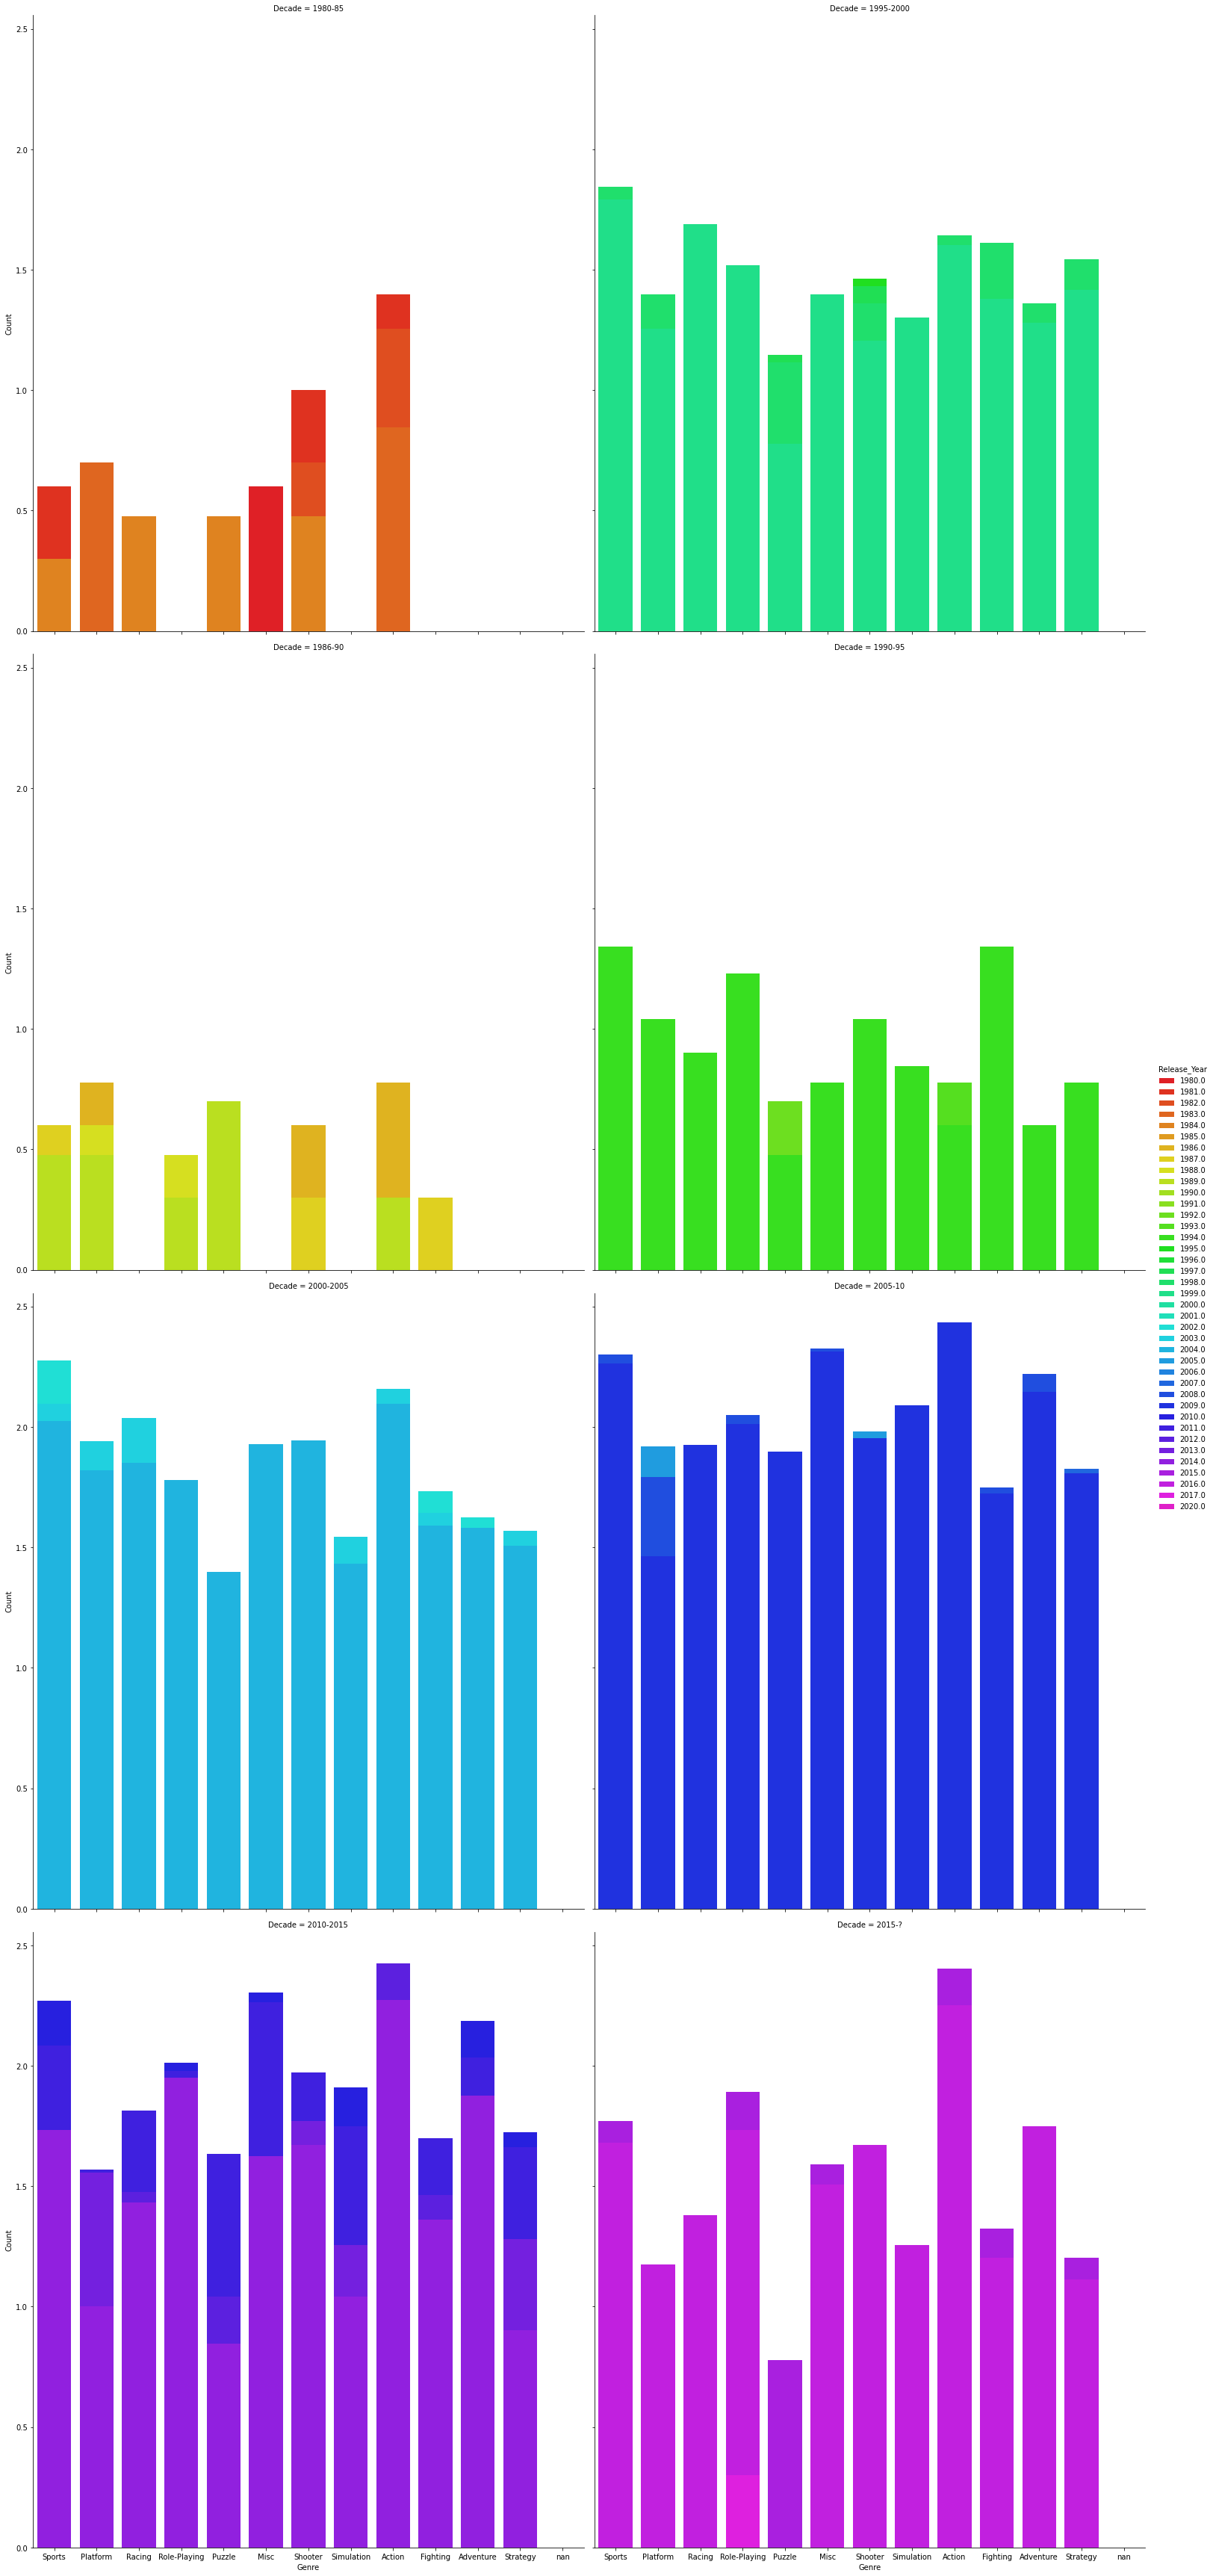

In [ ]:
fig = plt.gcf()

fig.set_size_inches(62, 32)
g = sns.FacetGrid(df_year_genre, col="Decade", hue="Release_Year", palette="gist_rainbow", col_wrap=2, height=12, aspect=0.9)
g.map(sns.barplot, "Genre", "Count", order=df_vg["Genre"].unique())
g.add_legend()
plt.show()

In [ ]:
df_genre_sales = df_vg.loc[:, ["Genre", "NA_Sales", "EU_Sales", "JP_Sales"]].groupby("Genre", as_index=False).sum()

top_genre_sales = df_genre_sales.sort_values(by=["NA_Sales"], ascending=False)[:10]

top_genre_sales

Genre  NA_Sales  EU_Sales  JP_Sales
0         Action    879.01    519.13    161.44
10        Sports    684.43    376.79    135.54
8        Shooter    592.24    317.34     38.76
4       Platform    445.50    200.35    130.83
3           Misc    407.27    212.74    108.11
6         Racing    359.35    236.51     56.71
7   Role-Playing    330.81    188.71    355.46
2       Fighting    223.36    100.33     87.48
9     Simulation    182.19    113.52     63.80
5         Puzzle    122.87     50.01     57.31

In [ ]:
ls_transpose = []

for gen in top_genre_sales["Genre"]:
  nas = top_genre_sales[top_genre_sales["Genre"] == gen]["NA_Sales"]
  jps = top_genre_sales[top_genre_sales["Genre"] == gen]["JP_Sales"]
  eus = top_genre_sales[top_genre_sales["Genre"] == gen]["EU_Sales"]

  for na in nas:
    ls_transpose.append((gen, na, "North America"))
  
  for jp in jps:
    ls_transpose.append((gen, jp, "Japan"))

  for eu in eus:
    ls_transpose.append((gen, eu, "Europe"))


df_tgs_t = pd.DataFrame.from_records(ls_transpose, columns=["Genre", "Millions Sold", "Region"])

df_tgs_t

Genre  Millions Sold         Region
0         Action         879.01  North America
1         Action         161.44          Japan
2         Action         519.13         Europe
3         Sports         684.43  North America
4         Sports         135.54          Japan
5         Sports         376.79         Europe
6        Shooter         592.24  North America
7        Shooter          38.76          Japan
8        Shooter         317.34         Europe
9       Platform         445.50  North America
10      Platform         130.83          Japan
11      Platform         200.35         Europe
12          Misc         407.27  North America
13          Misc         108.11          Japan
14          Misc         212.74         Europe
15        Racing         359.35  North America
16        Racing          56.71          Japan
17        Racing         236.51         Europe
18  Role-Playing         330.81  North America
19  Role-Playing         355.46          Japan
20  Role-Playing         188.71         Europe
21      Fighting         223.36  North America
22      Fighting          87.48          Japan
23      Fighting         100.33         Europe
24    Simulation         182.19  North America
25    Simulation          63.80          Japan
26    Simulation         113.52         Europe
27        Puzzle         122.87  North America
28        Puzzle          57.31          Japan
29        Puzzle          50.01         Europe

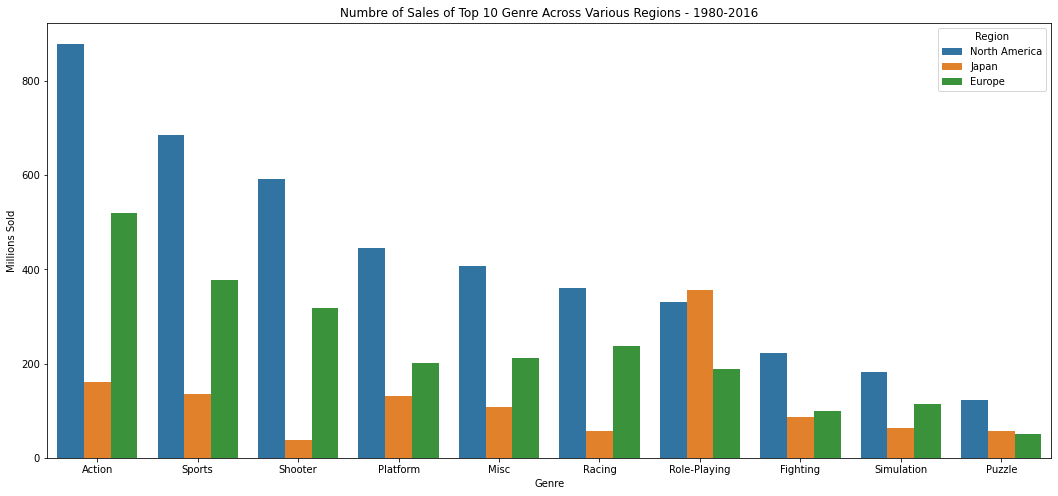

In [ ]:
fig = plt.gcf()

fig.set_size_inches(18, 8)
ax = sns.barplot(data=df_tgs_t, x="Genre", y="Millions Sold", hue="Region")
plt.title("Numbre of Sales of Top 10 Genre Across Various Regions - 1980-2016")
plt.show()

In [ ]:
df_cs_gen = df_vg.loc[:, ["Genre", "Critic_Score"]].dropna()

df_cs_gen

Genre  Critic_Score
0         Sports          76.0
2         Racing          82.0
3         Sports          80.0
6       Platform          89.0
7           Misc          58.0
...          ...           ...
16700    Shooter          61.0
16701     Puzzle          53.0
16702     Puzzle          48.0
16706   Strategy          60.0
16709  Adventure          63.0

[8137 rows x 2 columns]

In [ ]:
df_cs_gen_mean = df_cs_gen.groupby("Genre", as_index=False).mean()

df_cs_gen_mean

Genre  Critic_Score
0         Action     66.629101
1      Adventure     65.331269
2       Fighting     69.217604
3           Misc     66.619503
4       Platform     68.058350
5         Puzzle     67.424107
6         Racing     67.963612
7   Role-Playing     72.652646
8        Shooter     70.181144
9     Simulation     68.619318
10        Sports     71.968174
11      Strategy     72.086093

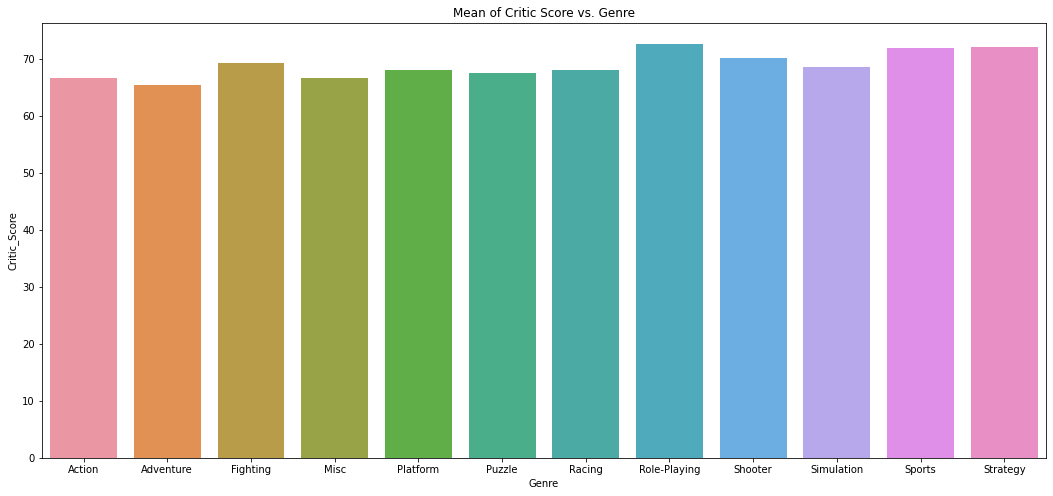

In [ ]:
fig = plt.gcf()

fig.set_size_inches(18, 8)

ax = sns.barplot(data=df_cs_gen_mean, x="Genre", y="Critic_Score")

plt.title("Mean of Critic Score vs. Genre")

plt.show()

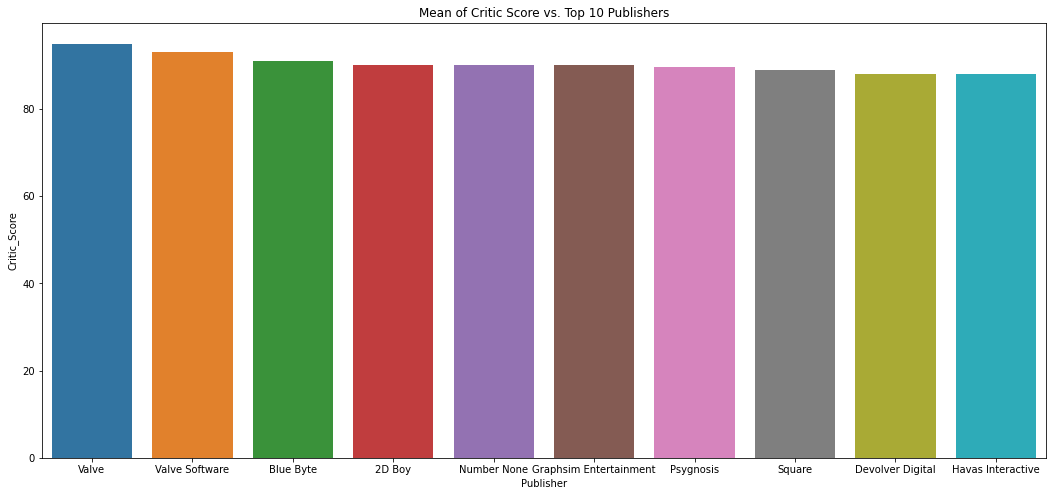

In [ ]:
df_cs_pub = df_vg.loc[:, ["Publisher", "Critic_Score"]].dropna()
df_cs_pub_mean = df_cs_pub.groupby("Publisher", as_index=False).mean().sort_values(by=["Critic_Score"], ascending=False)[:10]

fig = plt.gcf()

fig.set_size_inches(18, 8)

ax = sns.barplot(data=df_cs_pub_mean, x="Publisher", y="Critic_Score")

plt.title("Mean of Critic Score vs. Top 10 Publishers")

plt.show()


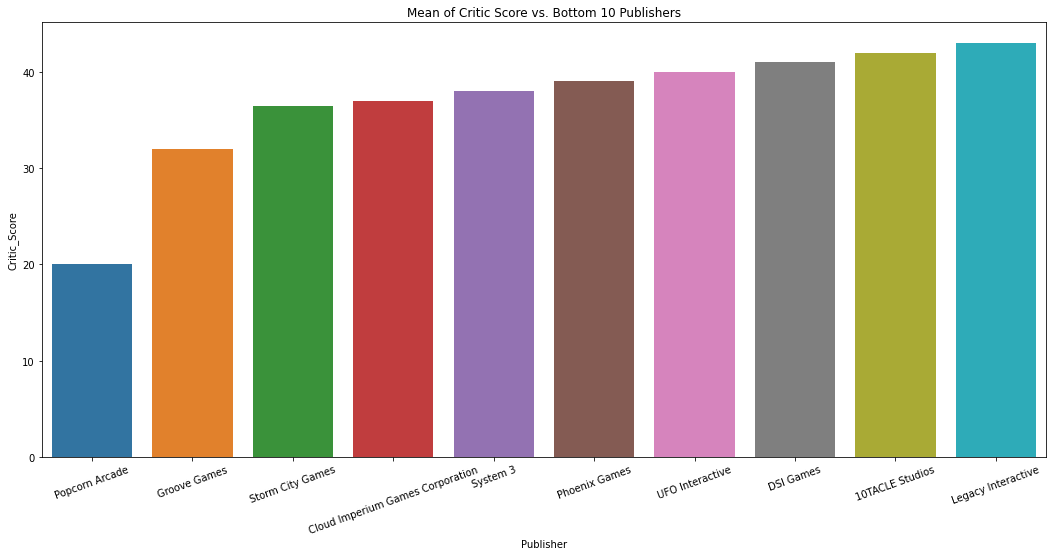

In [ ]:
df_cs_pub = df_vg.loc[:, ["Publisher", "Critic_Score"]].dropna()
df_cs_pub_mean = df_cs_pub.groupby("Publisher", as_index=False).mean().sort_values(by=["Critic_Score"], ascending=True)[:10]

fig = plt.gcf()

fig.set_size_inches(18, 8)

ax = sns.barplot(data=df_cs_pub_mean, x="Publisher", y="Critic_Score")

plt.title("Mean of Critic Score vs. Bottom 10 Publishers")

plt.xticks(rotation=20)
plt.show()


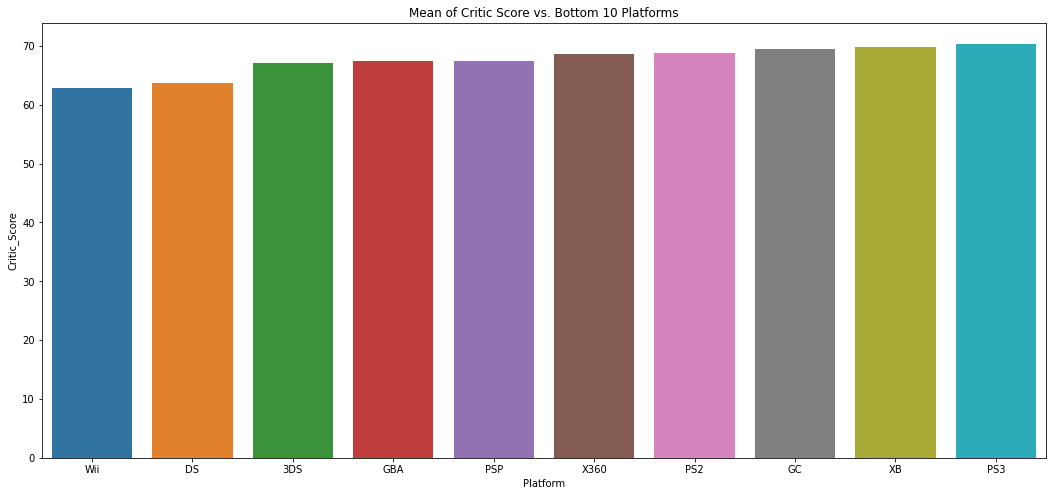

In [ ]:
df_cs_plat = df_vg.loc[:, ["Platform", "Critic_Score"]].dropna()
df_cs_plat_mean = df_cs_plat.groupby("Platform", as_index=False).mean().sort_values(by=["Critic_Score"], ascending=True)[:10]

fig = plt.gcf()

fig.set_size_inches(18, 8)

ax = sns.barplot(data=df_cs_plat_mean, x="Platform", y="Critic_Score")

plt.title("Mean of Critic Score vs. Bottom 10 Platforms")

plt.show()


In [ ]:
df_genre_gsales = df_vg.loc[:, ["Genre", "Global_Sales"]].groupby("Genre", as_index=False).sum()
df_pltsales_top = df_vg.loc[:, ["Platform", "Global_Sales"]].groupby("Platform", as_index=False).sum().sort_values(by=["Global_Sales"], ascending=False)[:10]
df_pltsales_bottom = df_vg.loc[:, ["Platform", "Global_Sales"]].groupby("Platform", as_index=False).sum().sort_values(by=["Global_Sales"], ascending=True)[:10]
df_pubsales_top = df_vg.loc[:, ["Publisher", "Global_Sales"]].groupby("Publisher", as_index=False).sum().sort_values(by=["Global_Sales"], ascending=False)[:10]
df_pubsales_bottom = df_vg.loc[:, ["Publisher", "Global_Sales"]].groupby("Publisher", as_index=False).sum().sort_values(by=["Global_Sales"], ascending=True)[:10]

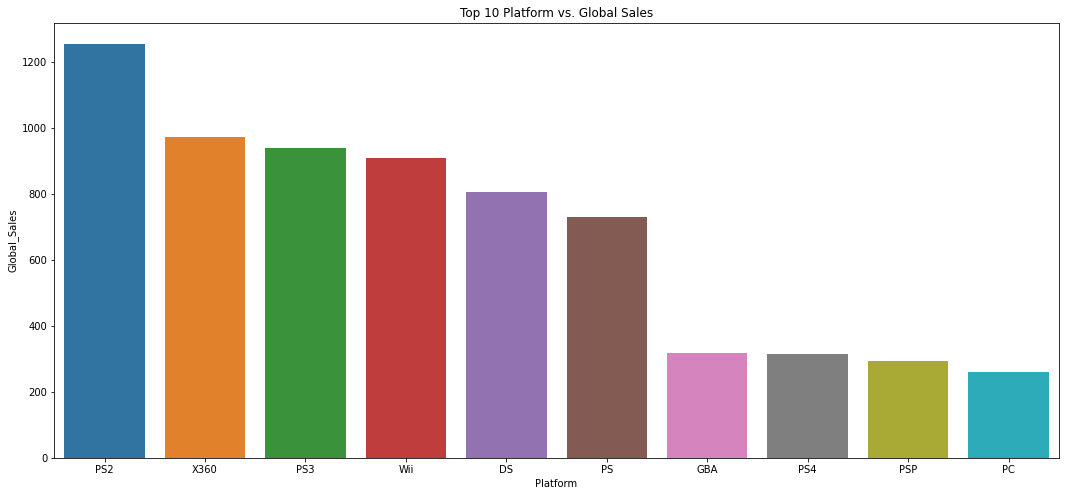

In [ ]:

fig = plt.gcf()

fig.set_size_inches(18, 8)

ax = sns.barplot(data=df_pltsales_top, x="Platform", y="Global_Sales")
plt.title("Top 10 Platform vs. Global Sales")
plt.show()

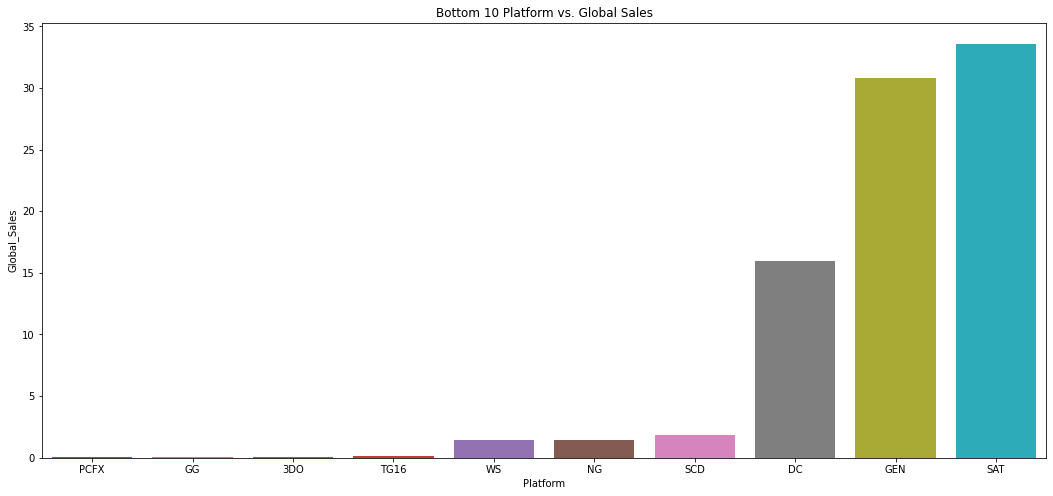

In [ ]:

fig = plt.gcf()

fig.set_size_inches(18, 8)

ax = sns.barplot(data=df_pltsales_bottom, x="Platform", y="Global_Sales")
plt.title("Bottom 10 Platform vs. Global Sales")
plt.show()

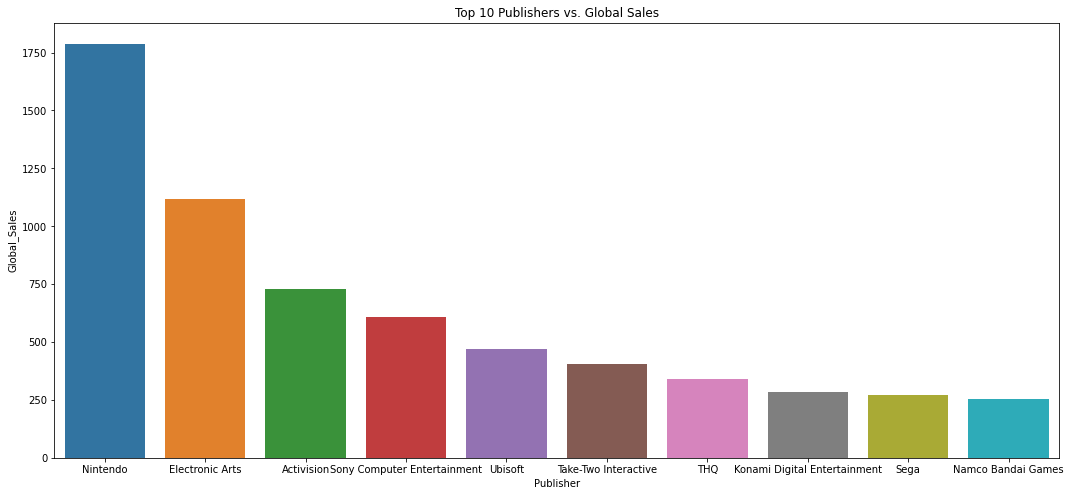

In [ ]:

fig = plt.gcf()

fig.set_size_inches(18, 8)

ax = sns.barplot(data=df_pubsales_top, x="Publisher", y="Global_Sales")
plt.title("Top 10 Publishers vs. Global Sales")
plt.show()

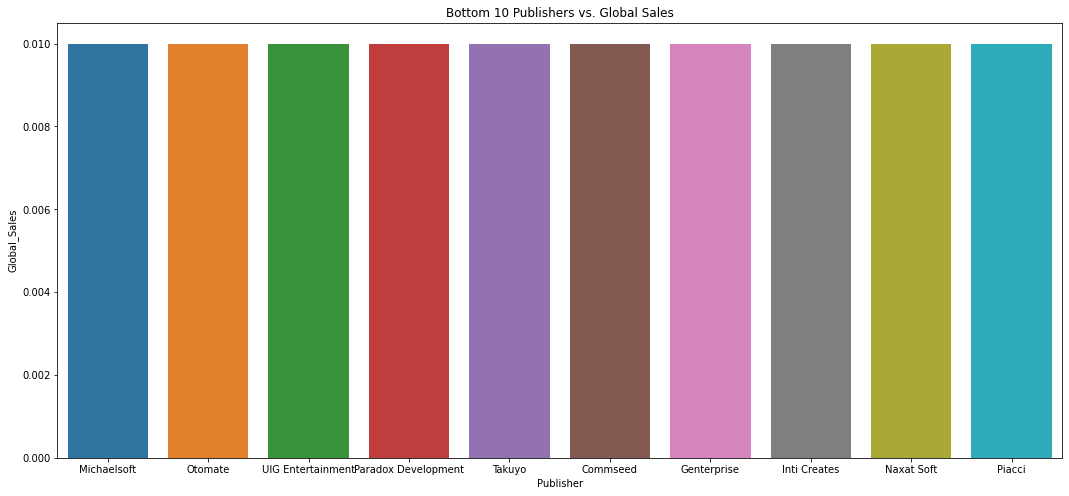

In [ ]:

fig = plt.gcf()

fig.set_size_inches(18, 8)

ax = sns.barplot(data=df_pubsales_bottom, x="Publisher", y="Global_Sales")
plt.title("Bottom 10 Publishers vs. Global Sales")

plt.show()

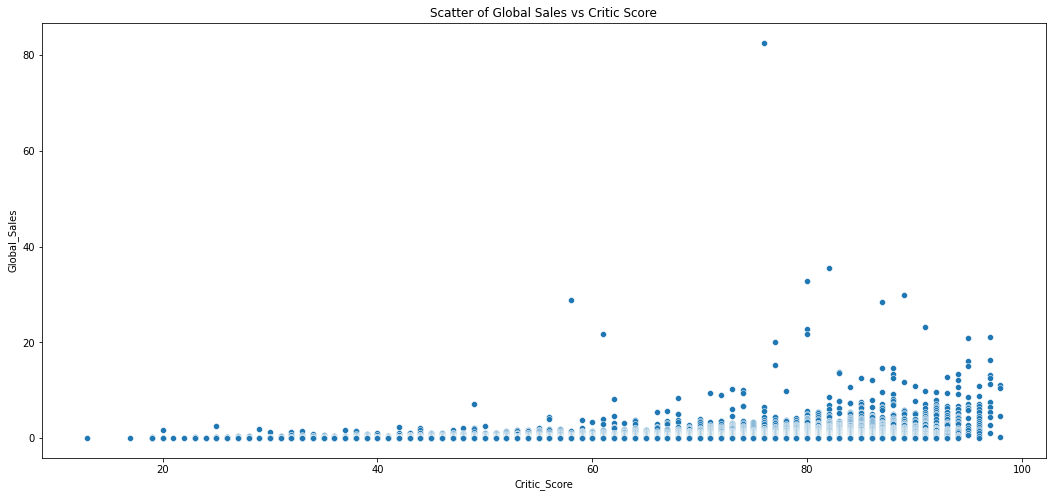

In [ ]:
df_cs_gs = df_vg.loc[:, ["Global_Sales", "Critic_Score"]].dropna()
fig = plt.gcf()

fig.set_size_inches(18, 8)
ax = sns.scatterplot(data=df_cs_gs, x="Critic_Score", y="Global_Sales")
plt.title("Scatter of Global Sales vs Critic Score")
plt.show()

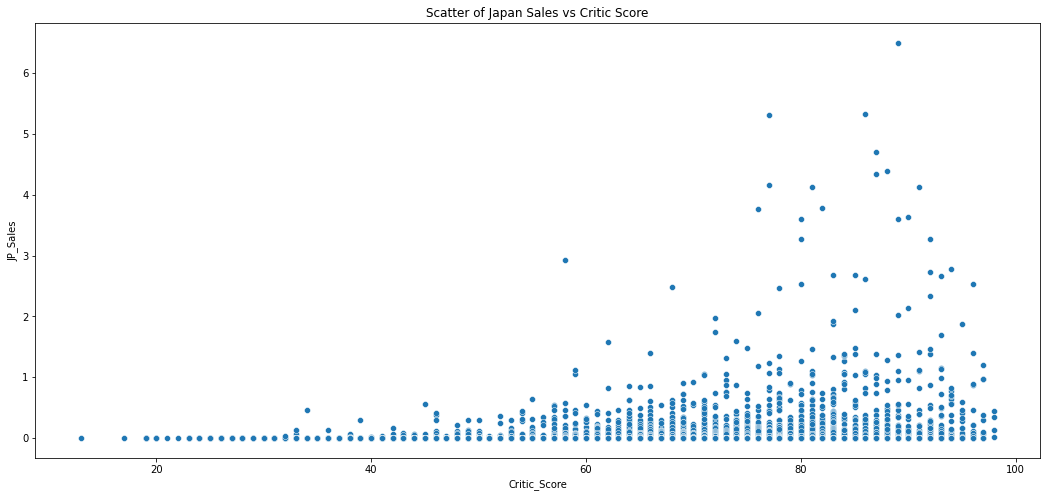

In [ ]:
 df_cs_gs = df_vg.loc[:, ["JP_Sales", "Critic_Score"]].dropna()
fig = plt.gcf()

fig.set_size_inches(18, 8)
ax = sns.scatterplot(data=df_cs_gs, x="Critic_Score", y="JP_Sales")
plt.title("Scatter of Japan Sales vs Critic Score")
plt.show()

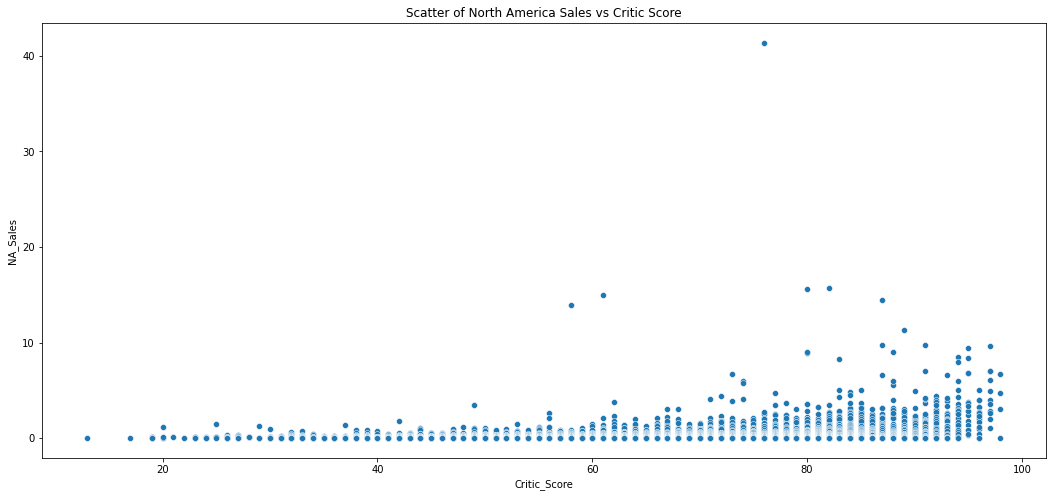

In [ ]:
 df_cs_gs = df_vg.loc[:, ["NA_Sales", "Critic_Score"]].dropna()
fig = plt.gcf()

fig.set_size_inches(18, 8)
ax = sns.scatterplot(data=df_cs_gs, x="Critic_Score", y="NA_Sales")
plt.title("Scatter of North America Sales vs Critic Score")
plt.show()

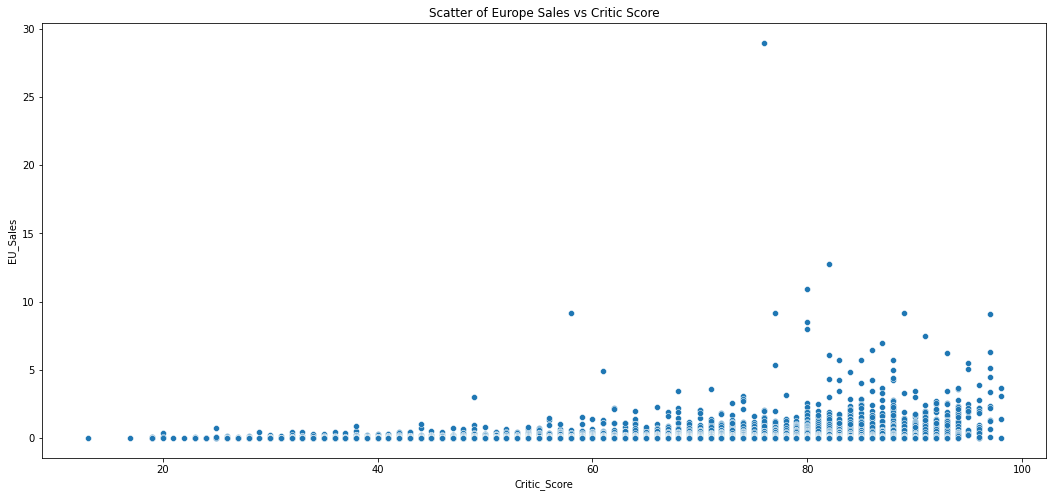

In [ ]:
 df_cs_gs = df_vg.loc[:, ["EU_Sales", "Critic_Score"]].dropna()
fig = plt.gcf()

fig.set_size_inches(18, 8)
ax = sns.scatterplot(data=df_cs_gs, x="Critic_Score", y="EU_Sales")
plt.title("Scatter of Europe Sales vs Critic Score")
plt.show()

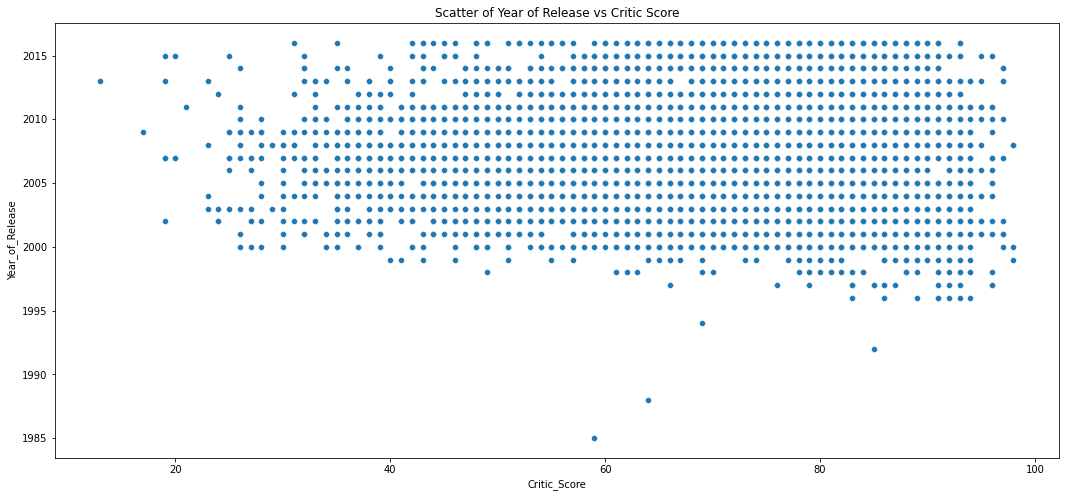

In [ ]:
 df_cs_yor = df_vg.loc[:, ["Year_of_Release", "Critic_Score"]].dropna()
fig = plt.gcf()

fig.set_size_inches(18, 8)
ax = sns.scatterplot(data=df_cs_yor, x="Critic_Score", y="Year_of_Release")
plt.title("Scatter of Year of Release vs Critic Score")
plt.show()

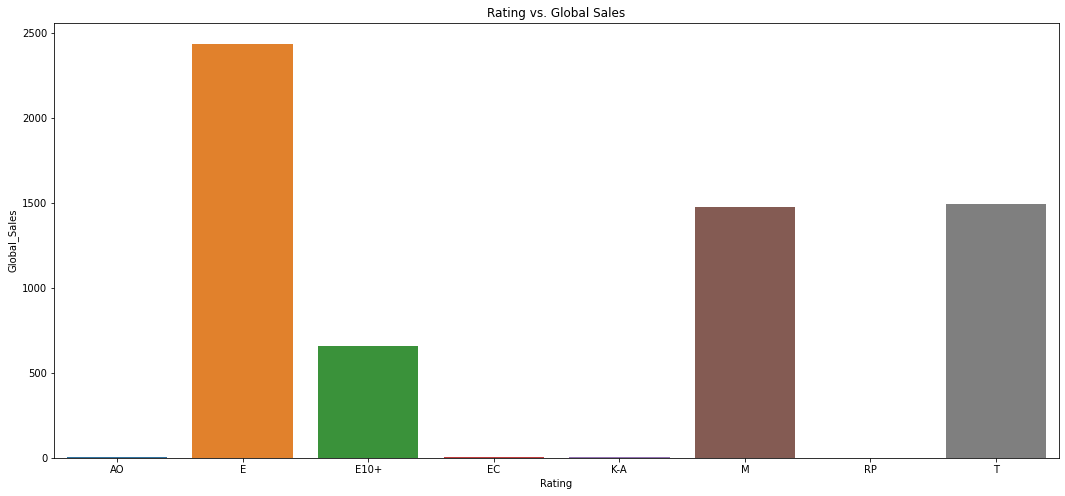

In [ ]:
df_rating_gsales = df_vg.loc[:, ["Rating", "Global_Sales"]].groupby("Rating", as_index=False).sum()

fig = plt.gcf()

fig.set_size_inches(18, 8)

ax = sns.barplot(data=df_rating_gsales, x="Rating", y="Global_Sales")
plt.title("Rating vs. Global Sales")
plt.show()

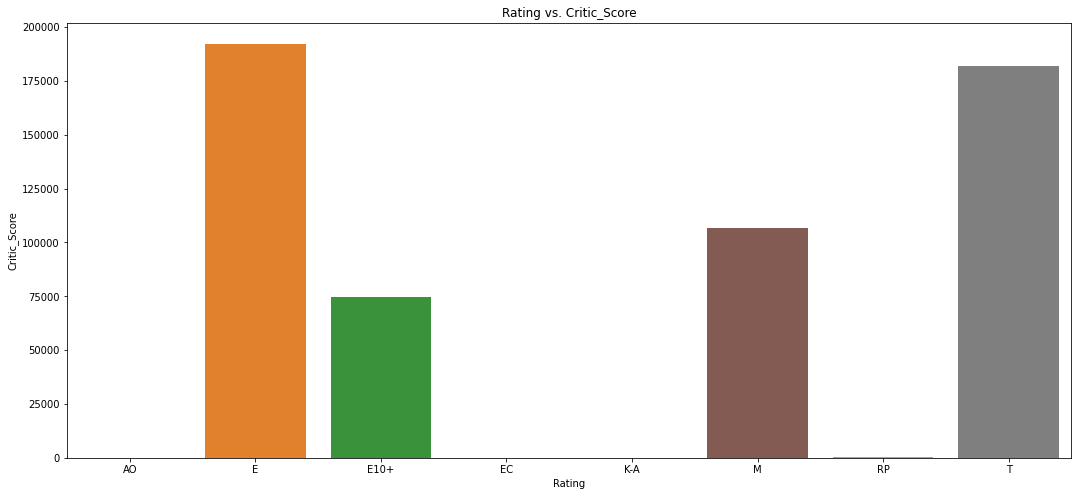

In [ ]:
df_rating_cs = df_vg.loc[:, ["Rating", "Critic_Score"]].groupby("Rating", as_index=False).sum()

fig = plt.gcf()

fig.set_size_inches(18, 8)

ax = sns.barplot(data=df_rating_cs, x="Rating", y="Critic_Score")
plt.title("Rating vs. Critic_Score")
plt.show()

<Figure size 4464x2304 with 0 Axes>

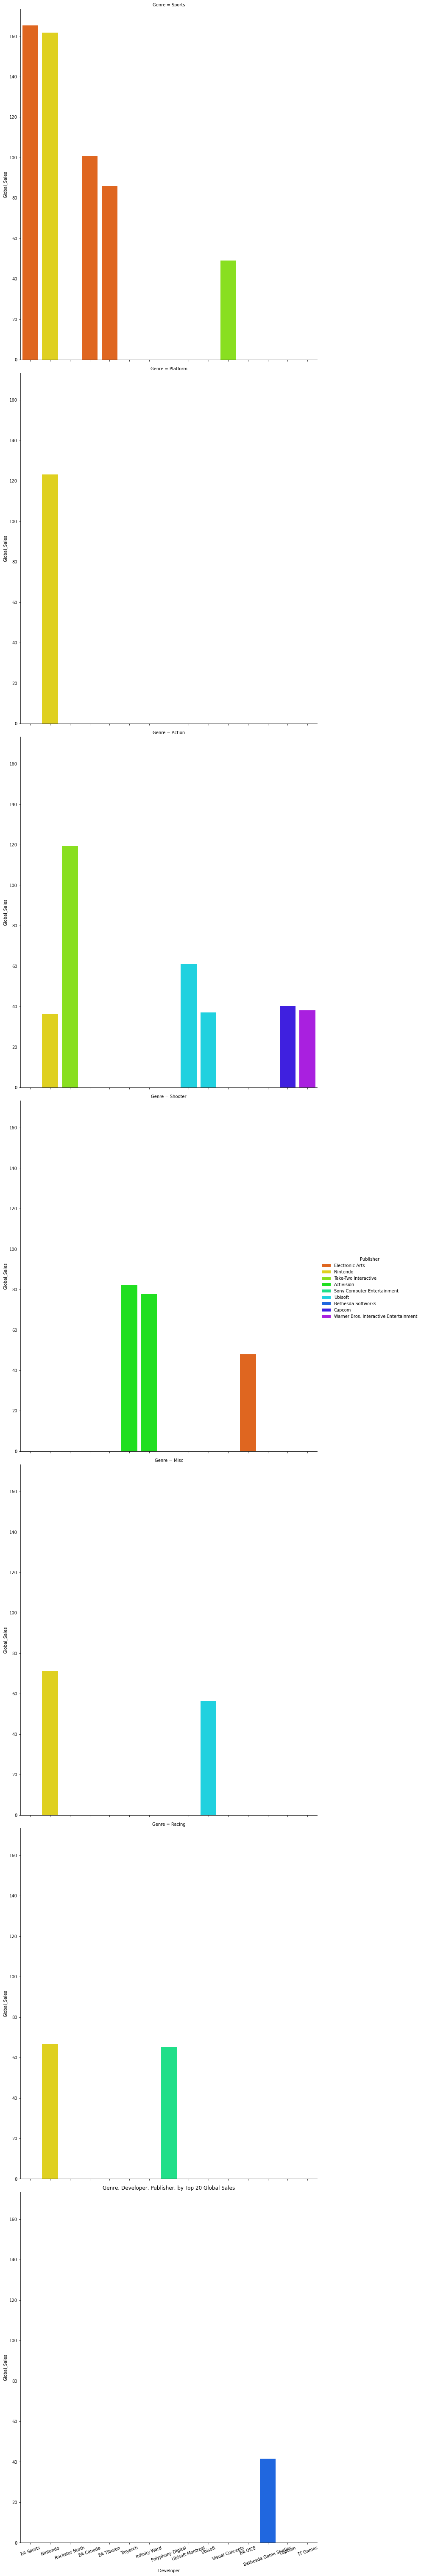

In [ ]:
df_gs_pd_genre = df_vg.loc[:, ["Genre", "Publisher", "Developer", "Global_Sales"]].dropna().groupby(["Genre", "Publisher", "Developer"], as_index=False).sum().sort_values(by=["Global_Sales"], ascending=False)[:20]


fig = plt.gcf()

fig.set_size_inches(62, 32)
g = sns.FacetGrid(df_gs_pd_genre, col="Genre", hue="Publisher", palette="gist_rainbow", col_wrap=1, height=12, aspect=0.9)
g.map(sns.barplot, "Developer", "Global_Sales", order=df_gs_pd_genre["Developer"].unique())
plt.xticks(rotation=20)
plt.title("Genre, Developer, Publisher, by Top 20 Global Sales")

g.add_legend()

plt.show()

<Figure size 4464x2304 with 0 Axes>

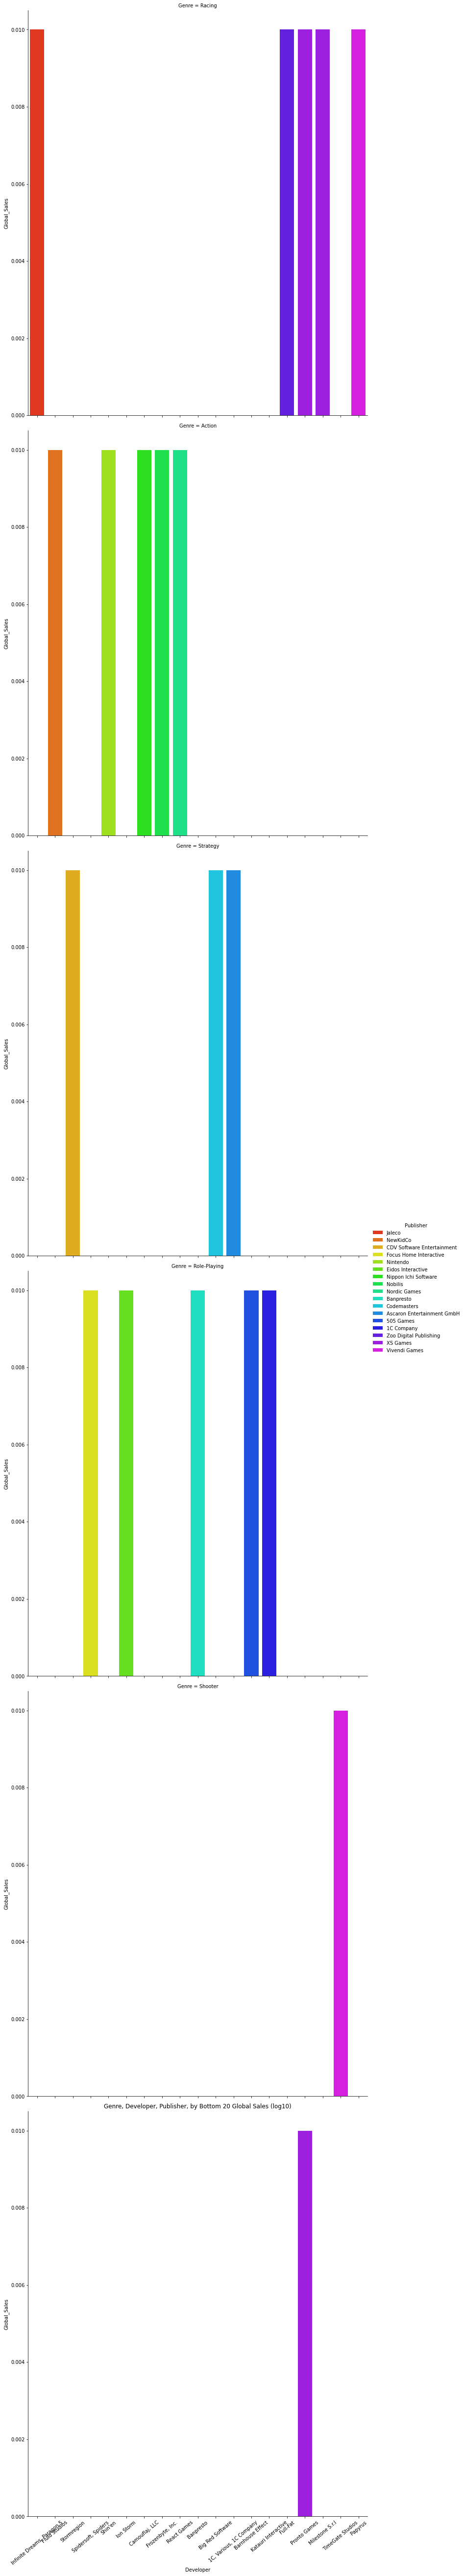

In [ ]:
df_gs_pd_genre = df_vg.loc[:, ["Genre", "Publisher", "Developer", "Global_Sales"]].dropna().groupby(["Genre", "Publisher", "Developer"], as_index=False).sum().sort_values(by=["Global_Sales"], ascending=True)[:20]


fig = plt.gcf()

fig.set_size_inches(62, 32)
g = sns.FacetGrid(df_gs_pd_genre, col="Genre", hue="Publisher", palette="gist_rainbow", col_wrap=1, height=12, aspect=0.9)
g.map(sns.barplot, "Developer", "Global_Sales", order=df_gs_pd_genre["Developer"].unique())
plt.xticks(rotation=40)
plt.title("Genre, Developer, Publisher, by Bottom 20 Global Sales (log10)")

g.add_legend()

plt.show()

<Figure size 4464x2304 with 0 Axes>

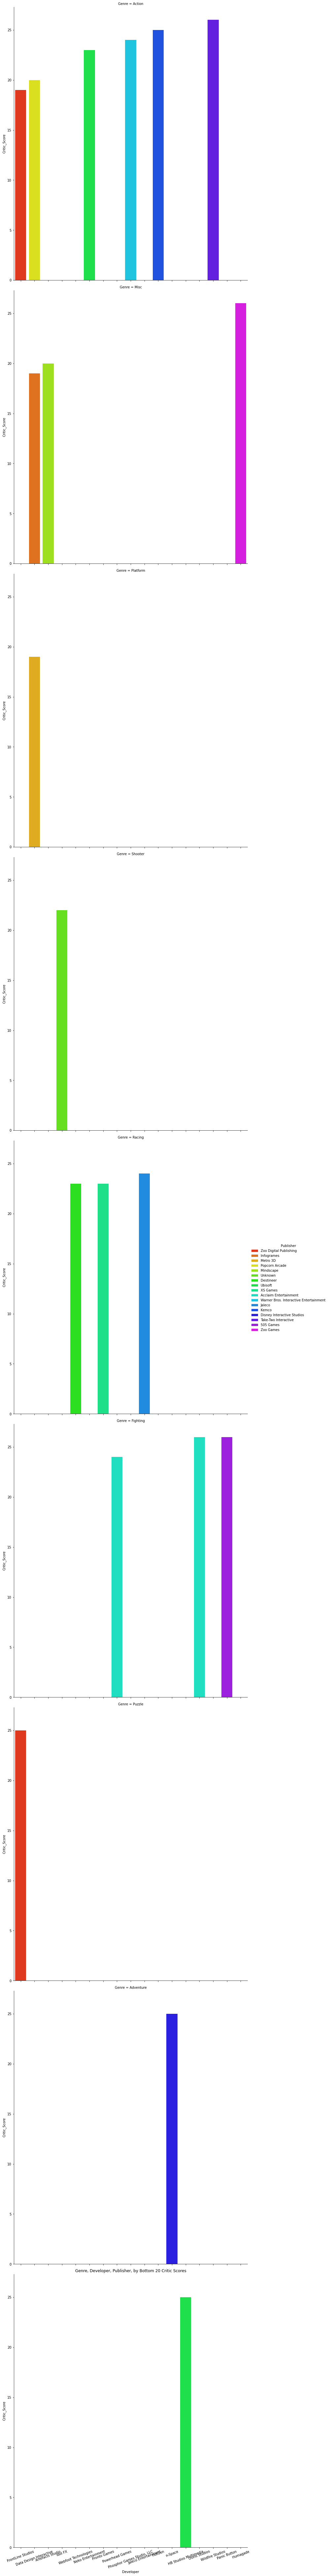

In [ ]:
df_gs_pd_genre = df_vg.loc[:, ["Genre", "Publisher", "Developer", "Critic_Score"]].dropna().groupby(["Genre", "Publisher", "Developer"], as_index=False).sum().sort_values(by=["Critic_Score"], ascending=True)[:20]


fig = plt.gcf()

fig.set_size_inches(62, 32)
g = sns.FacetGrid(df_gs_pd_genre, col="Genre", hue="Publisher", palette="gist_rainbow", col_wrap=1, height=12, aspect=0.9)
g.map(sns.barplot, "Developer", "Critic_Score", order=df_gs_pd_genre["Developer"].unique())
plt.xticks(rotation=20)
plt.title("Genre, Developer, Publisher, by Bottom 20 Critic Scores")

g.add_legend()

plt.show()

In [ ]:
df_rat_yor = df_vg.loc[:, ["Year_of_Release", "Rating"]].dropna()

ls_year_rating = []

for name, group in df_rat_yor.loc[:, ["Year_of_Release", "Rating"]].groupby("Year_of_Release"):
  
  if name == 'nan' or name == "KA" or name == "EC" or name == "AO" or name == "EC":
    continue

  count = group["Rating"].value_counts()

  if name >= 1980 and name < 1985:
    dec = "1980-85"
  elif name >= 1986 and name < 1990:
    dec = "1986-90"
  elif name >= 1990 and name < 1995:
    dec = "1990-95"
  elif name >= 1955 and name < 2000:
    dec = "1995-2000"
  elif name >= 2000 and name < 2005:
    dec = "2000-2005"
  elif name >= 2005 and name < 2010:
    dec = "2005-10"
  elif name >= 2010 and name < 2015:
    dec = "2010-2015"
  else:
    dec = "2015-?"

  for index, item in count.iteritems():
    if item < 25:
      continue

    ls_year_rating .append((name, index, item, dec))


df_year_rating = pd.DataFrame.from_records(ls_year_rating, columns=["Release_Year", "Rating", "Count", "Decade"])

df_year_rating = df_year_rating

df_year_rating

Release_Year Rating  Count     Decade
0         2000.0      E     83  2000-2005
1         2000.0      T     52  2000-2005
2         2001.0      E    205  2000-2005
3         2001.0      T    107  2000-2005
4         2001.0      M     27  2000-2005
..           ...    ...    ...        ...
57        2015.0   E10+     51     2015-?
58        2016.0      T     86     2015-?
59        2016.0      M     78     2015-?
60        2016.0      E     66     2015-?
61        2016.0   E10+     50     2015-?

[62 rows x 4 columns]

<Figure size 4464x2304 with 0 Axes>

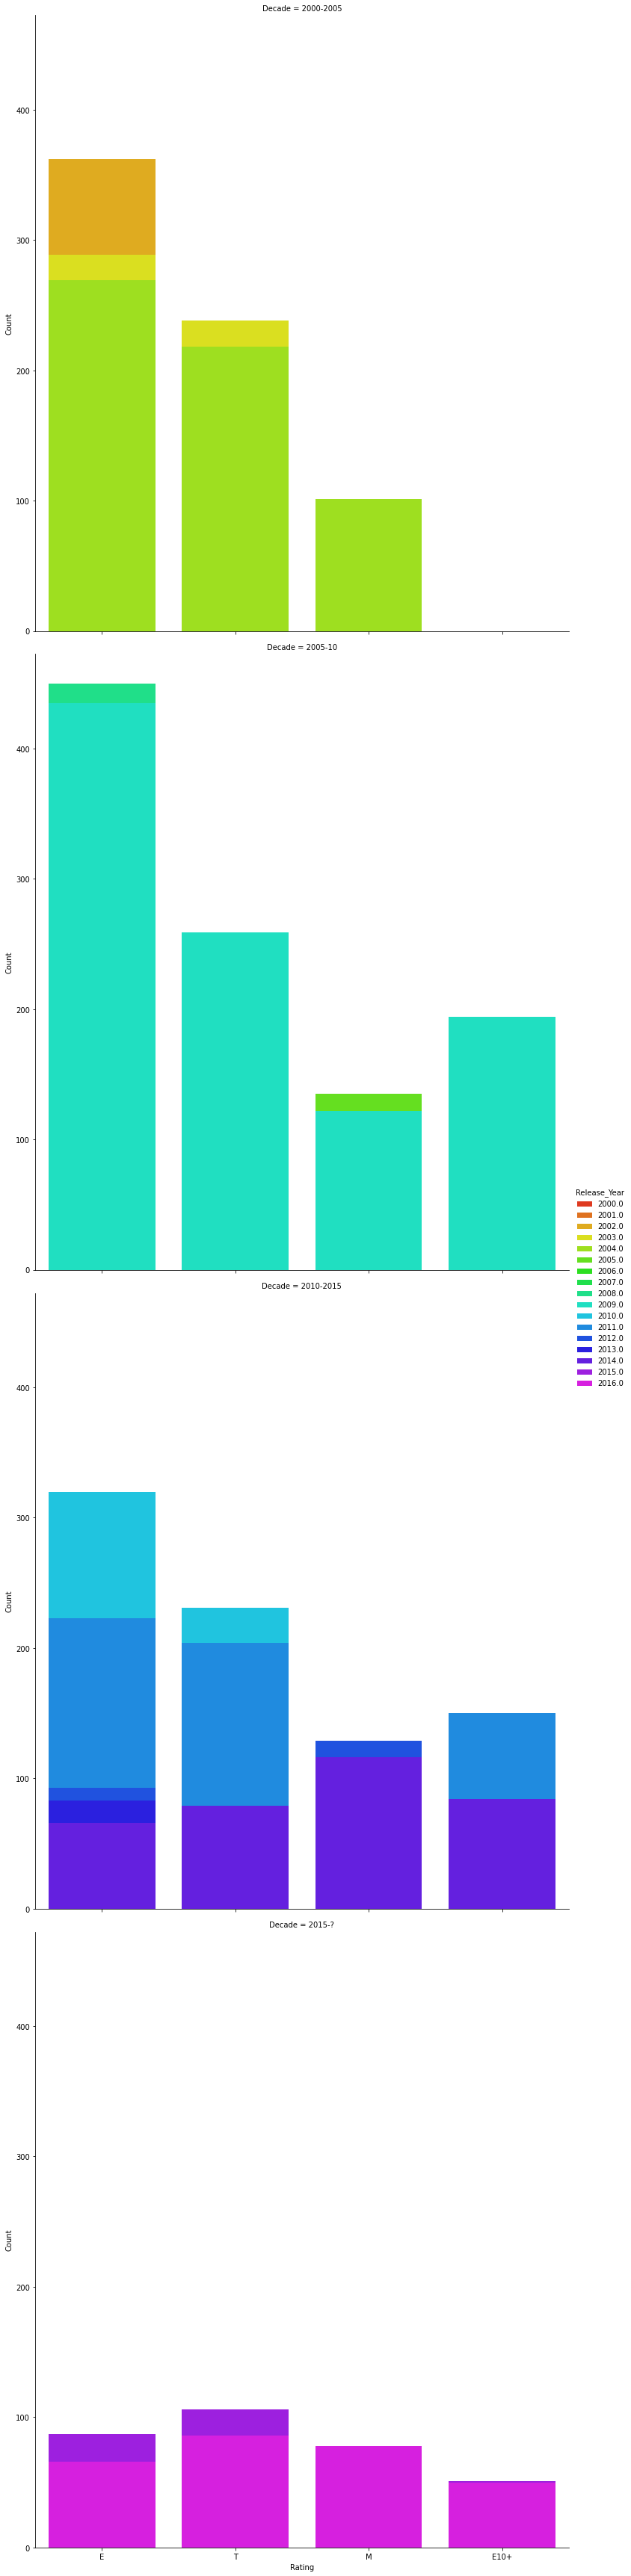

In [ ]:
fig = plt.gcf()

fig.set_size_inches(62, 32)
g = sns.FacetGrid(df_year_rating[df_year_rating["Rating"] != np.nan], col="Decade", hue="Release_Year", palette="gist_rainbow", col_wrap=1, height=12, aspect=0.9)
g.map(sns.barplot, "Rating", "Count", order=df_year_rating["Rating"].unique())
g.add_legend()
plt.show()

In [ ]:
df_super = df_vg.loc[:, ["Year_of_Release", "Genre", "Publisher", "Global_Sales", "Critic_Score"]].dropna()
df_super_X = df_super.loc[:, ["Year_of_Release", "Genre", "Publisher", "Global_Sales"]]
df_super_y = df_super.loc[:, "Critic_Score"]

le_genre = LabelEncoder()
le_pub = LabelEncoder()

le_genre.fit(df_super_X["Genre"])
le_pub.fit(df_super_X["Publisher"])

df_super_X["Genre"] = le_genre.transform(df_super_X["Genre"])
df_super_X["Publisher"] = le_pub.transform(df_super_X["Publisher"])


X_train, X_test, y_train, y_test = train_test_split(df_super_X, df_super_y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5986, 4) (1996, 4) (5986,) (1996,)


In [ ]:
estimator = RandomForestRegressor(random_state=420)
para_grids = {
            "n_estimators" : [10,50,100],
            "max_features" : ["auto", "log2", "sqrt"],
            "bootstrap"    : [True, False]
        }


grid = GridSearchCV(estimator, para_grids, scoring='neg_median_absolute_error')
grid.fit(X_train, y_train)
forest = grid.best_estimator_

reg_prediction=forest.predict(X_test)

print(grid.best_score_, grid.best_params_)

mae = mean_absolute_error(y_test, reg_prediction)

mae

-7.546666666666669 {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 100}


9.202421503999787

In [ ]:
print(np.where(le_pub.classes_ == "Electronic Arts"))
print(np.where(le_genre.classes_ == "Platform"))

(array([68]),)
(array([4]),)


In [ ]:
forest.predict(np.array([[2021, 185, 4, 48]]))

array([73.03])

In [ ]:
years = np.arange(2020, 2032)

cscores = []

for year in years:
  sales = np.random.randint(60, size=10)

  for sale in sales:
    for genre in range(0, le_genre.classes_.shape[0]):
      pred = forest.predict(np.array([[year, 185, genre, sale]]))

      cscores.append((year, le_genre.inverse_transform(np.array([genre]))[0], sale, pred[0]))

In [ ]:
df_cscores_nintendo = pd.DataFrame.from_records(cscores, columns=["Year", "Genre", "Sale", "Critic_Score_Prediction"])

df_cscores_nintendo

Year         Genre  Sale  Critic_Score_Prediction
0     2020        Action    57                    73.09
1     2020     Adventure    57                    73.09
2     2020      Fighting    57                    73.09
3     2020          Misc    57                    73.09
4     2020      Platform    57                    73.09
...    ...           ...   ...                      ...
1435  2031  Role-Playing    23                    75.68
1436  2031       Shooter    23                    81.83
1437  2031    Simulation    23                    81.83
1438  2031        Sports    23                    81.83
1439  2031      Strategy    23                    81.83

[1440 rows x 4 columns]

In [ ]:
df_nintendo_cscore_pred = df_cscores_nintendo.groupby(["Year", "Genre", "Sale"], as_index=False).mean()

df_nintendo_cscore_pred

Year     Genre  Sale  Critic_Score_Prediction
0     2020    Action    19                    73.16
1     2020    Action    20                    73.16
2     2020    Action    21                    73.14
3     2020    Action    36                    73.03
4     2020    Action    38                    73.03
...    ...       ...   ...                      ...
1303  2031  Strategy    41                    81.63
1304  2031  Strategy    46                    81.63
1305  2031  Strategy    48                    81.63
1306  2031  Strategy    49                    81.45
1307  2031  Strategy    55                    81.45

[1308 rows x 4 columns]

Text(0.5, 1.0, 'Prediction of Nintendo Game Scores based on Sales by Genre in 2021 to 2031')

<Figure size 4464x2304 with 0 Axes>

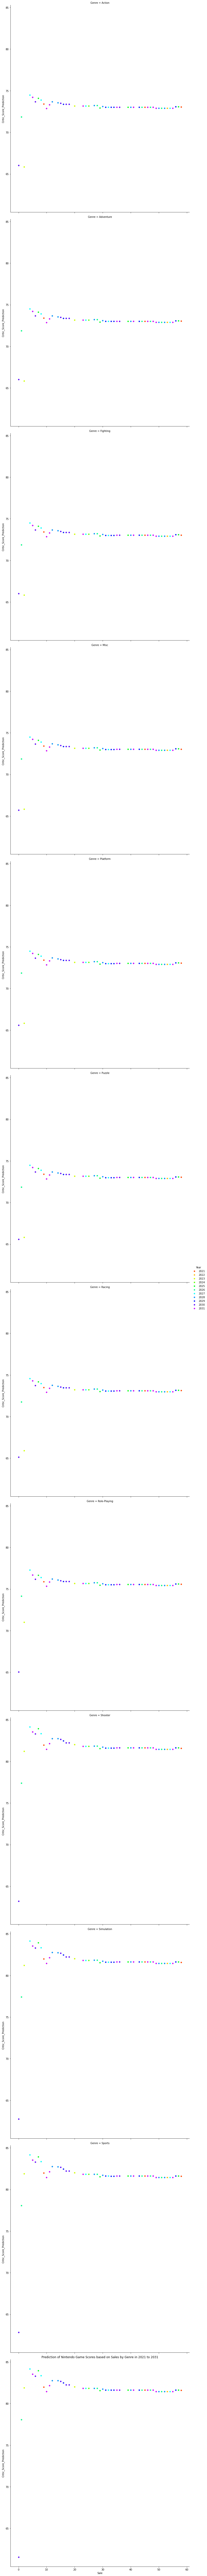

In [ ]:
fig = plt.gcf()

fig.set_size_inches(62, 32)
g = sns.FacetGrid(df_nintendo_cscore_pred[df_nintendo_cscore_pred["Year"] != 2020], col="Genre", hue="Year", palette="gist_rainbow", col_wrap=1, height=12, aspect=0.9)
g.map(sns.scatterplot, "Sale", "Critic_Score_Prediction")
g.add_legend()
plt.savefig("nintendo.svg")
plt.title("Prediction of Nintendo Game Scores based on Sales by Genre in 2021 to 2031")

In [ ]:
years = np.arange(2021, 2032)

cscores_acti = []

for year in years:
  sales = np.random.randint(100, size=10)

  for sale in sales:
    for genre in range(0, le_genre.classes_.shape[0]):
      pred = forest.predict(np.array([[year, 11, genre, sale]]))

      cscores_acti.append((year, le_genre.inverse_transform(np.array([genre]))[0], sale, pred[0]))

In [ ]:
df_cscores_acti = pd.DataFrame.from_records(cscores_acti, columns=["Year", "Genre", "Sale", "Critic_Score_Prediction"])

df_acti_cscore_pred = df_cscores_acti.groupby(["Year", "Genre", "Sale"], as_index=False).mean()

df_acti_cscore_pred

Year     Genre  Sale  Critic_Score_Prediction
0     2021    Action     1                    71.87
1     2021    Action     3                    72.72
2     2021    Action    16                    73.38
3     2021    Action    41                    73.03
4     2021    Action    44                    73.03
...    ...       ...   ...                      ...
1243  2031  Strategy    62                    81.47
1244  2031  Strategy    85                    81.47
1245  2031  Strategy    87                    81.47
1246  2031  Strategy    90                    81.47
1247  2031  Strategy    95                    81.47

[1248 rows x 4 columns]

Text(0.5, 1.0, 'Prediction of Activision Game Scores based on Sales by Genre in 2021 to 2031')

<Figure size 4464x2304 with 0 Axes>

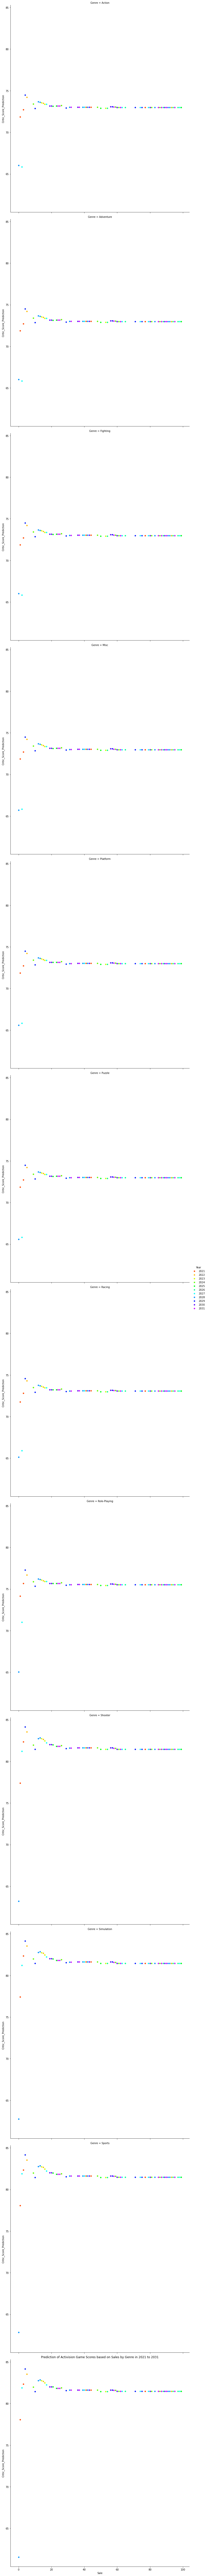

In [ ]:
fig = plt.gcf()

fig.set_size_inches(62, 32)
g = sns.FacetGrid(df_acti_cscore_pred, col="Genre", hue="Year", palette="gist_rainbow", col_wrap=1, height=12, aspect=0.9)
g.map(sns.scatterplot, "Sale", "Critic_Score_Prediction")
g.add_legend()
plt.title("Prediction of Activision Game Scores based on Sales by Genre in 2021 to 2031")

Text(0.5, 1.0, 'Prediction of EA Game Scores based on Sales by Genre in 2021 to 2031')

<Figure size 4464x2304 with 0 Axes>

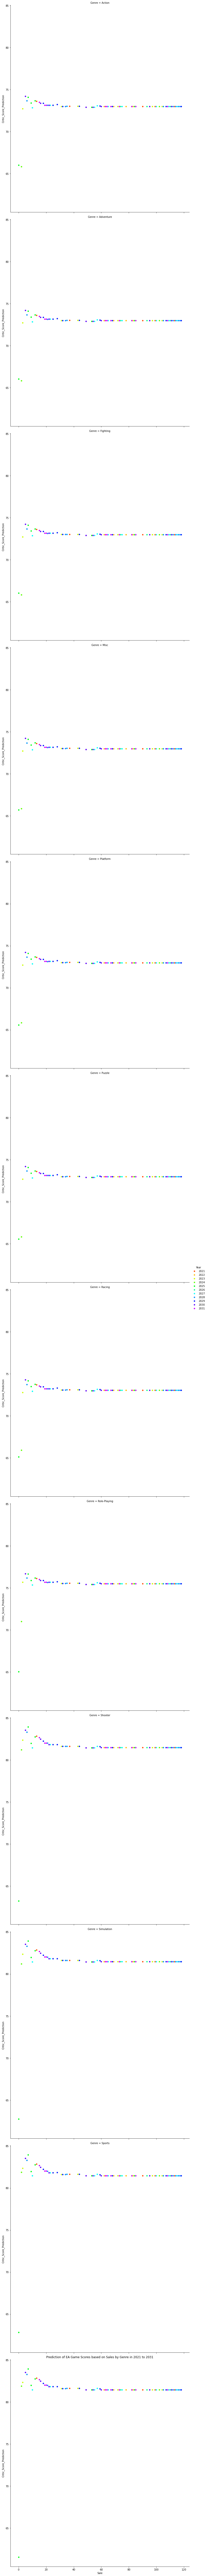

In [ ]:
years = np.arange(2021, 2032)

cscores_ea = []

for year in years:
  sales = np.random.randint(120, size=10)

  for sale in sales:
    for genre in range(0, le_genre.classes_.shape[0]):
      pred = forest.predict(np.array([[year, 68, genre, sale]]))

      cscores_ea.append((year, le_genre.inverse_transform(np.array([genre]))[0], sale, pred[0]))


df_cscores_ea = pd.DataFrame.from_records(cscores_ea, columns=["Year", "Genre", "Sale", "Critic_Score_Prediction"])

df_ea_cscore_pred = df_cscores_ea.groupby(["Year", "Genre", "Sale"], as_index=False).mean()


fig = plt.gcf()

fig.set_size_inches(62, 32)
g = sns.FacetGrid(df_ea_cscore_pred, col="Genre", hue="Year", palette="gist_rainbow", col_wrap=1, height=12, aspect=0.9)
g.map(sns.scatterplot, "Sale", "Critic_Score_Prediction")
g.add_legend()
plt.title("Prediction of EA Game Scores based on Sales by Genre in 2021 to 2031")

Text(0.5, 1.0, 'Prediction of Ubisoft Game Scores based on Sales by Genre in 2021 to 2031')

<Figure size 4464x2304 with 0 Axes>

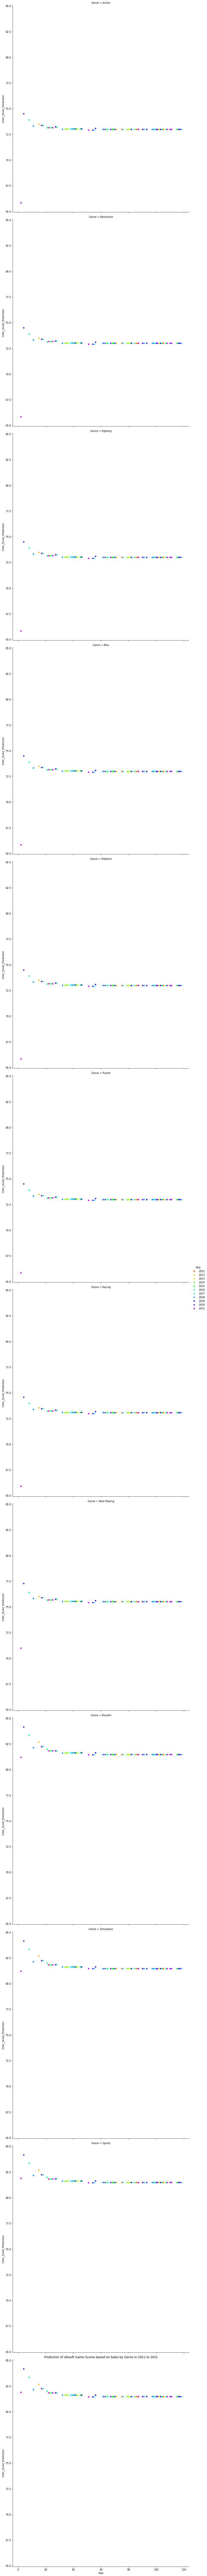

In [ ]:
years = np.arange(2021, 2032)

cscores_ubi = []

for year in years:
  sales = np.random.randint(120, size=10)

  for sale in sales:
    for genre in range(0, le_genre.classes_.shape[0]):
      pred = forest.predict(np.array([[year, 274, genre, sale]]))

      cscores_ubi.append((year, le_genre.inverse_transform(np.array([genre]))[0], sale, pred[0]))


df_cscores_ubi = pd.DataFrame.from_records(cscores_ubi, columns=["Year", "Genre", "Sale", "Critic_Score_Prediction"])

df_ubi_cscore_pred = df_cscores_ubi.groupby(["Year", "Genre", "Sale"], as_index=False).mean()


fig = plt.gcf()

fig.set_size_inches(62, 32)
g = sns.FacetGrid(df_ubi_cscore_pred, col="Genre", hue="Year", palette="gist_rainbow", col_wrap=1, height=12, aspect=0.9)
g.map(sns.scatterplot, "Sale", "Critic_Score_Prediction")
g.add_legend()
plt.title("Prediction of Ubisoft Game Scores based on Sales by Genre in 2021 to 2031")

Text(0.5, 1.0, 'Prediction of Valve Game Scores based on Sales by Genre in 2021 to 2031')

<Figure size 4464x2304 with 0 Axes>

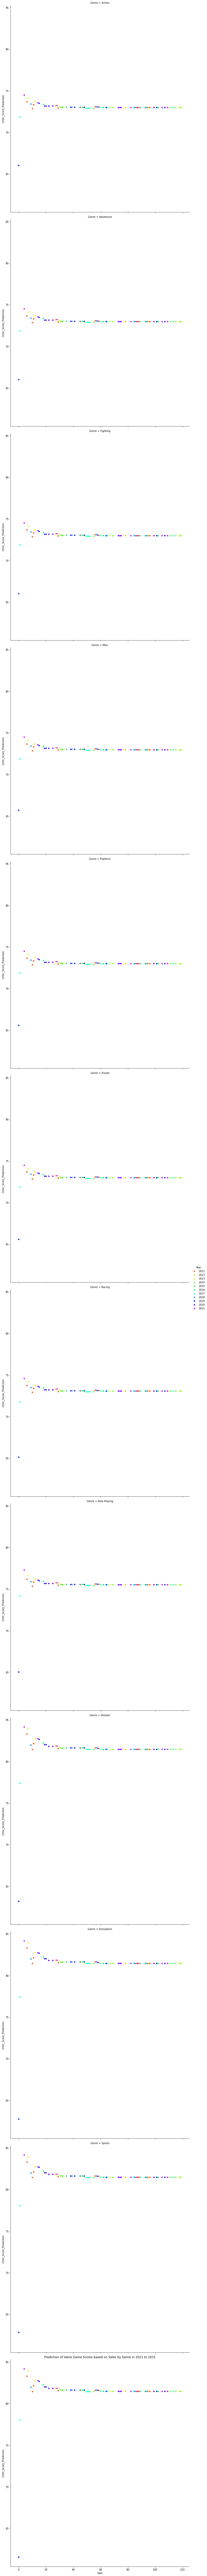

In [ ]:
years = np.arange(2021, 2032)

cscores_vlv = []

for year in years:
  sales = np.random.randint(120, size=10)

  for sale in sales:
    for genre in range(0, le_genre.classes_.shape[0]):
      pred = forest.predict(np.array([[year, 279, genre, sale]]))

      cscores_vlv.append((year, le_genre.inverse_transform(np.array([genre]))[0], sale, pred[0]))


df_cscores_vlv = pd.DataFrame.from_records(cscores_vlv, columns=["Year", "Genre", "Sale", "Critic_Score_Prediction"])

df_vlv_cscore_pred = df_cscores_vlv.groupby(["Year", "Genre", "Sale"], as_index=False).mean()


fig = plt.gcf()

fig.set_size_inches(62, 32)
g = sns.FacetGrid(df_vlv_cscore_pred, col="Genre", hue="Year", palette="gist_rainbow", col_wrap=1, height=12, aspect=0.9)
g.map(sns.scatterplot, "Sale", "Critic_Score_Prediction")
g.add_legend()
plt.title("Prediction of Valve Game Scores based on Sales by Genre in 2021 to 2031")

Text(0.5, 1.0, 'Prediction of Take-Two Interactive Game Scores based on Sales by Genre in 2021 to 2031')

<Figure size 4464x2304 with 0 Axes>

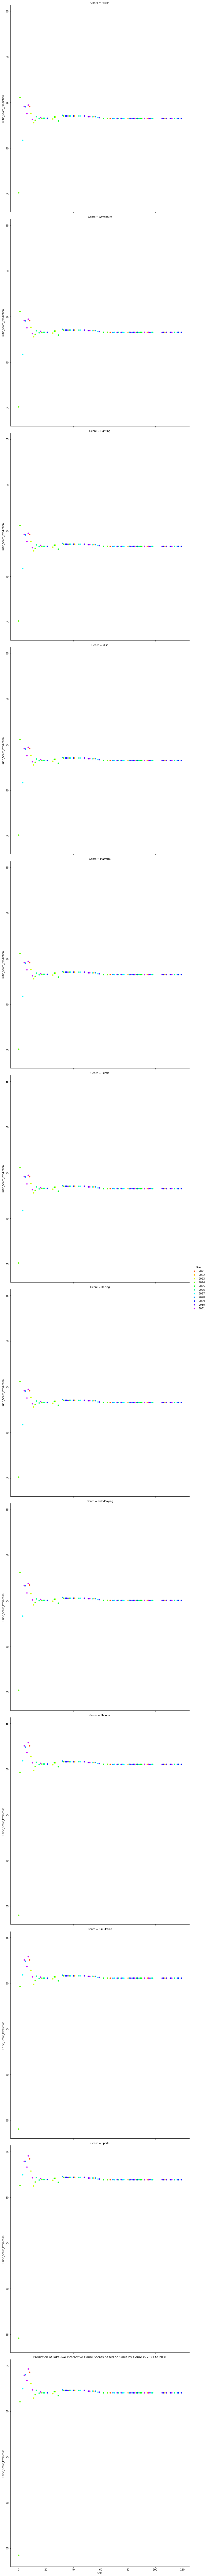

In [ ]:
years = np.arange(2021, 2032)

cscores_t2 = []

for year in years:
  sales = np.random.randint(120, size=10)

  for sale in sales:
    for genre in range(0, le_genre.classes_.shape[0]):
      pred = forest.predict(np.array([[year, 259, genre, sale]]))

      cscores_t2.append((year, le_genre.inverse_transform(np.array([genre]))[0], sale, pred[0]))


df_cscores_t2 = pd.DataFrame.from_records(cscores_t2, columns=["Year", "Genre", "Sale", "Critic_Score_Prediction"])

df_t2_cscore_pred = df_cscores_t2.groupby(["Year", "Genre", "Sale"], as_index=False).mean()


fig = plt.gcf()

fig.set_size_inches(62, 32)
g = sns.FacetGrid(df_t2_cscore_pred, col="Genre", hue="Year", palette="gist_rainbow", col_wrap=1, height=12, aspect=0.9)
g.map(sns.scatterplot, "Sale", "Critic_Score_Prediction")
g.add_legend()
plt.title("Prediction of Take-Two Interactive Game Scores based on Sales by Genre in 2021 to 2031")

In [ ]:
df_score = df_vg["Critic_Score"].dropna()

size = df_score.shape[0]
true_intercept = 1
true_slope = 2

x = df_score.values
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

In [ ]:
with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy('sigma', beta=10, testval=1.)
    intercept = Normal('Intercept', 0, sigma=20)
    x_coeff = Normal('x', 0, sigma=20)

    # Define likelihood
    likelihood = Normal('y', mu=intercept + x_coeff * x,
                        sigma=sigma, observed=y)

    # Inference!
    trace = sample(3000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]
Sampling 2 chains: 100%|██████████| 7000/7000 [15:31<00:00,  7.52draws/s]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9980696508835323, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9947821204265294, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not conv

Text(0, 0.5, 'y')

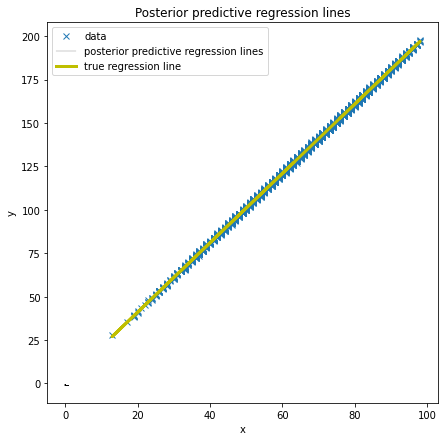

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
plot_posterior_predictive_glm(trace, samples=100,
                              label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
estimator = AdaBoostRegressor()
para_grids = {
            "n_estimators" : [10,50,100],
            "loss" : ['linear', 'square', 'exponential'],
            "random_state" : [None, 10, 100]
        }


grid = GridSearchCV(estimator, para_grids, scoring='neg_median_absolute_error')
grid.fit(X_train, y_train)
ada = grid.best_estimator_

reg_prediction=ada.predict(X_test)

print(grid.best_score_, grid.best_params_)

mae = mean_absolute_error(y_test, reg_prediction)

mae

-8.805200656537483 {'loss': 'exponential', 'n_estimators': 10, 'random_state': None}


10.19845358239694

Text(0.5, 1.0, 'Prediction of Electronic Interactive Game Scores based on Sales by Genre in 2021 to 2031')

<Figure size 4464x2304 with 0 Axes>

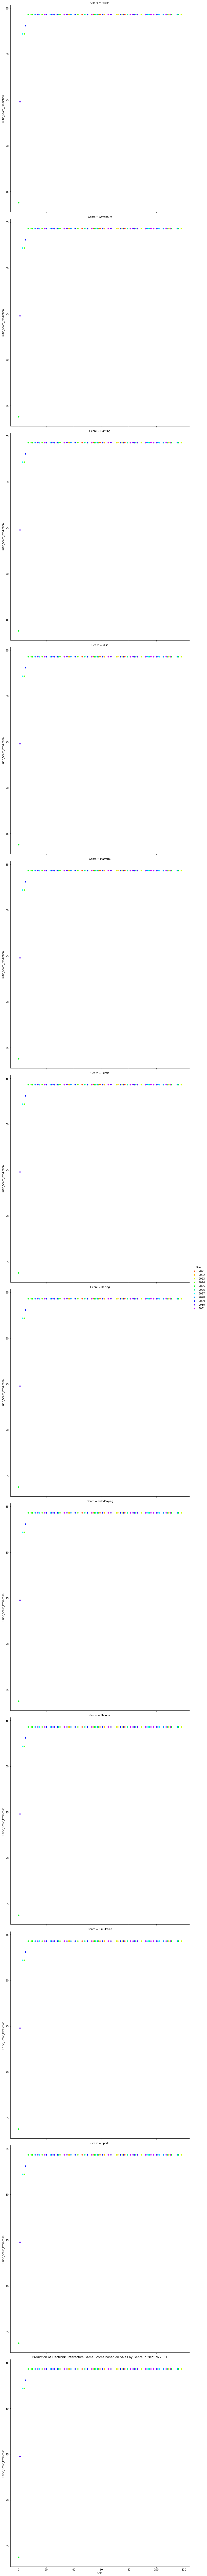

In [ ]:
years = np.arange(2021, 2032)

cscores_t2 = []

for year in years:
  sales = np.random.randint(120, size=10)

  for sale in sales:
    for genre in range(0, le_genre.classes_.shape[0]):
      pred = ada.predict(np.array([[year, 68, genre, sale]]))

      cscores_t2.append((year, le_genre.inverse_transform(np.array([genre]))[0], sale, pred[0]))


df_cscores_t2 = pd.DataFrame.from_records(cscores_t2, columns=["Year", "Genre", "Sale", "Critic_Score_Prediction"])

df_t2_cscore_pred = df_cscores_t2.groupby(["Year", "Genre", "Sale"], as_index=False).mean()


fig = plt.gcf()

fig.set_size_inches(62, 32)
g = sns.FacetGrid(df_t2_cscore_pred, col="Genre", hue="Year", palette="gist_rainbow", col_wrap=1, height=12, aspect=0.9)
g.map(sns.scatterplot, "Sale", "Critic_Score_Prediction")
g.add_legend()
plt.title("Prediction of Electronic Interactive Game Scores based on Sales by Genre in 2021 to 2031")

In [5]:
text = " ".join(list(df_vg["Name"].astype(str).values))

def generateTable(data,k=4):
    
    T = {}
    for i in range(len(data)-k):
        X = data[i:i+k]
        Y = data[i+k]
        #print("X  %s and Y %s  "%(X,Y))
        
        if T.get(X) is None:
            T[X] = {}
            T[X][Y] = 1
        else:
            if T[X].get(Y) is None:
                T[X][Y] = 1
            else:
                T[X][Y] += 1
    
    return T

T = generateTable(text)
print(T)

{'Wii ': {'S': 6, 'W': 1, 'P': 4, 'D': 3, 'F': 4, 'U': 4, 'M': 3, '&': 6, 'L': 1, '2': 1, 'C': 1, 'E': 2, 'd': 3, 'T': 1, 'K': 1, 'N': 2}, 'ii S': {'p': 3, 'u': 1, 'e': 1, 'h': 1, 'o': 1}, 'i Sp': {'o': 4, 'i': 2, 'y': 1, 'e': 3}, ' Spo': {'r': 102, 'n': 55, 't': 5, 'o': 8}, 'Spor': {'t': 109, 'e': 5}, 'port': {'s': 105, ' ': 24, ':': 5, 'f': 1, 'e': 1}, 'orts': {' ': 90, ':': 16, 'm': 2}, 'rts ': {'S': 11, 'R': 4, 'P': 8, 'G': 6, 'I': 6, 'A': 7, 'C': 10, 'M': 5, '3': 6, 'H': 1, 'U': 4, '2': 16, 'T': 3, 'D': 7, 'F': 8, 'B': 4, 'J': 2, 'V': 1, 'E': 1, 'N': 3, 'o': 2, 'O': 1, 'Y': 1, 'K': 1}, 'ts S': {'u': 5, 't': 7, 'o': 4, 'N': 1, 'i': 2, 'h': 8, 'l': 1, 'p': 3, 'c': 2, 'e': 2, 'a': 3, 'n': 1, 'k': 2}, 's Su': {'p': 36, 'd': 2, 'm': 3, 'r': 5, 'z': 1, 's': 1, 'n': 1, 'g': 2}, ' Sup': {'e': 389, 'r': 12, 'p': 2}, 'Supe': {'r': 389}, 'uper': {' ': 293, 's': 28, 'S': 9, 'c': 13, 'N': 2, 'n': 3, 'C': 8, 'm': 10, 'b': 15, 'F': 3, 'p': 3, 'h': 2, '-': 1, 'd': 1}, 'per ': {'M': 60, 'S': 49, '

In [6]:
def convertFreqIntoProb(T):     
    for kx in T.keys():
        s = float(sum(T[kx].values()))
        for k in T[kx].keys():
            T[kx][k] = T[kx][k]/s
                
    return T
 
T = convertFreqIntoProb(T)
print(T)

{'Wii ': {'S': 0.13953488372093023, 'W': 0.023255813953488372, 'P': 0.09302325581395349, 'D': 0.06976744186046512, 'F': 0.09302325581395349, 'U': 0.09302325581395349, 'M': 0.06976744186046512, '&': 0.13953488372093023, 'L': 0.023255813953488372, '2': 0.023255813953488372, 'C': 0.023255813953488372, 'E': 0.046511627906976744, 'd': 0.06976744186046512, 'T': 0.023255813953488372, 'K': 0.023255813953488372, 'N': 0.046511627906976744}, 'ii S': {'p': 0.42857142857142855, 'u': 0.14285714285714285, 'e': 0.14285714285714285, 'h': 0.14285714285714285, 'o': 0.14285714285714285}, 'i Sp': {'o': 0.4, 'i': 0.2, 'y': 0.1, 'e': 0.3}, ' Spo': {'r': 0.6, 'n': 0.3235294117647059, 't': 0.029411764705882353, 'o': 0.047058823529411764}, 'Spor': {'t': 0.956140350877193, 'e': 0.043859649122807015}, 'port': {'s': 0.7720588235294118, ' ': 0.17647058823529413, ':': 0.03676470588235294, 'f': 0.007352941176470588, 'e': 0.007352941176470588}, 'orts': {' ': 0.8333333333333334, ':': 0.14814814814814814, 'm': 0.0185185

In [7]:
def MarkovChain(text,k=4):
    T = generateTable(text,k)
    T = convertFreqIntoProb(T)
    return T

In [8]:
model = MarkovChain(text)

In [9]:
def sample_next(ctx,model,k):
 
    ctx = ctx[-k:]
    if model.get(ctx) is None:
        return " "
    possible_Chars = list(model[ctx].keys())
    possible_values = list(model[ctx].values())
    
    print(possible_Chars)
    print(possible_values)
 
    return np.random.choice(possible_Chars,p=possible_values)

In [10]:
def generateText(starting_sent,k=4,maxLen=1000):
    
    sentence = starting_sent
    ctx = starting_sent[-k:]
    
    for ix in range(maxLen):
        next_prediction = sample_next(ctx,model,k)
        sentence += next_prediction
        ctx = sentence[-k:]
    return sentence

In [23]:
generateText("Childish",k=4,maxLen=15)

[':']
[1.0]
[' ']
[1.0]
['E', 'T', 'A', 'M', 'J', 'S', 'G', 'F', 'K', 'R']
[0.09523809523809523, 0.19047619047619047, 0.09523809523809523, 0.23809523809523808, 0.09523809523809523, 0.09523809523809523, 0.047619047619047616, 0.047619047619047616, 0.047619047619047616, 0.047619047619047616]
['i']
[1.0]
['n', 's', 'l', 'c', 'a', 'd', 'r', 'g', 't', 'y']
[0.2857142857142857, 0.1836734693877551, 0.1836734693877551, 0.02040816326530612, 0.061224489795918366, 0.061224489795918366, 0.12244897959183673, 0.02040816326530612, 0.04081632653061224, 0.02040816326530612]
['n', 'd', 'w', 't', 'o']
[0.41304347826086957, 0.1956521739130435, 0.32608695652173914, 0.021739130434782608, 0.043478260869565216]
['a']
[1.0]
['y']
[1.0]
[' ', "'"]
[0.9130434782608695, 0.08695652173913043]
['T', 'S', 'A', 'F', 'L', 't', 'P', 'V', 'D', 'U', 'G', 'N', 'B', '9', 'K', 'I', 'R', 'C', 'u', 'M']
[0.058823529411764705, 0.1568627450980392, 0.19607843137254902, 0.0196078431372549, 0.0196078431372549, 0.0392156862745098, 0.

'Childish: Midway Dream '